# Data Augmentation - Conditional Wasserstein GANs - GP

### Dataset: Human Dataset

This notebook presents the CWGAN-GP model to generate Feature Occurrence or Binary Data from the experimental human dataset.

Notebook Organization:
- Read the dataset
- Setup the CWGAN-GP Binary model and train the model with human feature occurrence data
- Generate artificial samples in an artificial dataset and compare them to the experimental data
- Train 7 models each only with 15 samples of either class, using the remaining samples as the test set to test to see performance of supervised analysis using real or GAN generated data
- Some of the optimizations made to the model

#### Due to stochasticity, re-running the notebook will get slightly different results. Thus, figures in the report can be slightly different than the ones shown here (since some parts of the notebooks were re-ran after submission).

Warnings in certain cells are suppressed with %%capture --no-stdout. Erase the line to see warnings.

#### Needed Imports

In [1]:
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
from collections import namedtuple, Counter

from tqdm import tqdm
from IPython import display as ipythondisplay

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble

import tensorflow as tf
import os
from keras import backend

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse
import gan_evaluation_metrics as gem
import linear_augmentation_functions as laf

In [2]:
%matplotlib inline

Reading the data to be analysed and augmented

#### Loading Human dataset

Note: Require 'ST001082_AN001766_HD.xlsx' file.

In [3]:
# Reading the dataset, this dataset has two copies of the samples.The 2nd copy is equal to the 1st multiplied by a constant
# unique to each sample.
human_datamatrix_base = pd.read_excel('ST001082_AN001766_HD.xlsx')

In [4]:
human_datamatrix = human_datamatrix_base.iloc[:-1, :-4] # Just select the rows corresponding to the dataset
mz_list = human_datamatrix_base.iloc[:-1, -4] # Select column with list of m/z values

human_datamatrix = human_datamatrix.set_index(human_datamatrix.columns[0]) # Set index as the metabolites name
human_datamatrix = human_datamatrix.replace({0:np.nan}) # Replacing 0 values as missing values

human_datamatrix

,2_Pooled_Sample_1,2_Pooled_Sample_1_2,P2_2,P2_3,P2_4,Psp_1,Psp_2,Psp_3,Psp_4,Psp_5,...,S67_3.1,S70_1.1,S70_2.1,S70_3.1,S72_1.1,S72_2.1,S72_3.1,S77_1.1,S77_2.1,S77_3.1
metabolite_name,,,,,,,,,,,,,,,,,,,,,
Factors,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,...,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence
95.06024579_7.857483333,2544.256904,2174.683995,2349.405324,2142.906787,2633.130278,2510.239989,3619.82127,2217.770816,2894.966994,20587.0328,...,4121.029059,3834.23691,4090.323428,3830.272712,3705.545567,3954.147516,3740.035077,3837.308267,4164.971893,4155.190276
71.06031304_0.064166667,153.7382834,2972.450721,951.0420238,2861.700714,3339.380877,299.8124672,783.1155979,3034.247021,3511.131943,NaN,...,8012.257751,853.7856117,6297.664545,7257.02521,845.5966076,6130.01575,7499.72554,796.3862056,5999.547509,7583.908921
71.06031992_9.984466667,292.2381888,1598.405492,638.9111168,1659.297423,1855.933656,382.0675008,948.3162562,1707.100565,1981.102653,62862.60997,...,4440.820011,662.2607137,3347.680062,4147.143726,694.8464783,3388.086581,4194.416655,650.7198089,3381.510189,4134.43322
126.1023924_4.038416667,347.8838312,125.0657553,260.8042864,119.6837125,NaN,803.1992227,NaN,126.2802051,0.001242692,582.9410185,...,322.3904954,4488.12769,3755.93028,1616.363518,1806.669855,1365.45848,495.4602756,1993.623747,1663.073748,1059.509693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588.4147684_2.0983,12264.30083,1935.998098,2697.901871,1761.340872,369.0957455,12243.27287,574.4747938,221.0599403,11.37397281,NaN,...,NaN,6225.892205,NaN,NaN,8491.983882,NaN,NaN,9425.946784,358.953733,NaN
177.1270579_2.0983,4477.875444,317.9191822,2573.952315,69.97337036,NaN,5703.699795,NaN,477.9239747,960.7144488,NaN,...,5104.451502,NaN,248.6690155,4012.400432,189.415007,1938.392231,5601.351328,NaN,25.42248559,4329.675354
374.2064688_2.0983,7056.085863,112.7816239,4444.488636,NaN,NaN,6690.765635,NaN,462.1335736,572.3140362,NaN,...,6158.786604,NaN,NaN,3297.509597,NaN,NaN,2256.379266,NaN,NaN,7587.036926


In [5]:
# Select one of the two copies of samples in the dataset by removing the samples ending with '.1'
human_datamatrix = human_datamatrix[[i for i in human_datamatrix.columns if not i.endswith('.1')]]

human_datamatrix = human_datamatrix.T # Transpose the dataset

In [6]:
# Current sample labels. Sample will consist of 'Sample Type:No Recurrence' and 'Sample Type:Recurrence'
hd_labels = list(human_datamatrix['Factors'])
set(hd_labels)

{'Sample Type:Blank',
 'Sample Type:No Recurrence',
 'Sample Type:Pooled',
 'Sample Type:Recurrence'}

In [7]:
# How many 'No Recurrence' samples in the dataset
hd_labels.count('Sample Type:No Recurrence')

135

### Blank Treatment

- If blank_treatment = True:

An average of the blanks will be subtracted to the remaining dataset. Missing values in the blanks were replaced by 0 to calculate the average of the blanks. Negative values that arise in the dataset from subtracting the blanks will be coded as 0/missing values in the dataset.

- If blank_treatment = False:

Blank samples are removed and not accounted for. 

In [8]:
blank_treatment = True
#blank_treatment = False

In [9]:
if blank_treatment:
    blanks = human_datamatrix[human_datamatrix['Factors'] == 'Sample Type:Blank'].iloc[:,1:] # Select blank samples
    blanks = blanks.replace({np.nan:0}) 
    blanks = blanks.astype(float) # Get blank samples with floats (needed since datamatrix has strings)
    blanks_average = blanks.mean() # Average of the blanks
    blanks_average

In [10]:
# Selecting the samples belonging to either the 'No Recurrence' or 'Recurrence' 
selection = []
for i in human_datamatrix.loc[:, 'Factors']:
    if i in ['Sample Type:No Recurrence', 'Sample Type:Recurrence']:
        selection.append(True)
    else:
        selection.append(False)

In [11]:
human_datamatrix = human_datamatrix[selection]
# Creating the list of 'targets' (labels of samples) of the dataset with the 'No Recurrence' and 'Recurrence' classes 
hd_labels = []
for i in list(human_datamatrix.iloc[:,0]):
    if i == 'Sample Type:No Recurrence':
        hd_labels.append('No Recurrence')
    else:
        hd_labels.append('Recurrence')

In [12]:
human_datamatrix = human_datamatrix.iloc[:,1:]
human_datamatrix

metabolite_name,95.06024579_7.857483333,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,88.05051567_0.095966667,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S10_1,5839.689646,2421.207099,1702.403305,1732.645968,11202.3156,13.77354446,15969.09873,11122.92882,76033.09098,15559.66213,...,549.5061406,1788.00406,237.4614192,3065.766426,170.0414581,1347.054595,479.0767276,NaN,NaN,41.58211389
S10_2,4925.936713,6760.239327,3927.481184,876.2460627,16464.75568,144.7380541,11235.281,17168.89308,50955.48348,17634.72493,...,2354.284435,428.9492324,6.856593556,126.8752621,6686.085356,NaN,5663.904982,11572.89831,1720.669345,3969.969384
S10_3,5530.737291,11234.04531,6138.510579,302.5141329,24441.42344,196.744245,6281.973729,23329.82436,38668.17711,17924.91677,...,1187.542997,8.16828659,4.535420845,NaN,6985.148407,5.695198924,5001.930045,9622.04692,1835.400914,3534.540622
S15_1,4345.962212,1647.020375,1087.357218,2044.425809,4820.244022,8.539063852,10824.9497,2858.654761,48787.91979,12293.8573,...,NaN,2378.896459,578.7754145,NaN,155.6123097,2164.462213,936.4502838,NaN,NaN,66.89873449
S15_2,4135.848719,7164.394072,3594.221384,1396.827349,6507.869956,56.61978795,8963.260007,6670.576787,49360.26082,23406.46182,...,NaN,437.5625196,11.89033556,1.767176652,1485.254178,73.86922602,1952.194542,NaN,NaN,282.3818514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,4042.390453,6266.816562,3463.69699,1395.930804,10517.7526,97.700184,17988.63512,4597.778125,24216.15305,23606.86636,...,7049.366359,NaN,0.910517997,1273.048903,3601.773523,NaN,1981.650461,NaN,3938.848802,144.146236
S72_3,3860.581052,7741.451008,4329.607912,511.4295756,15224.61293,594.5983793,9768.49416,7663.919663,17897.95381,12847.39403,...,5875.548618,NaN,0.355728465,NaN,15046.7641,NaN,5781.889838,2329.105172,4675.475887,1257.137318
S77_1,4741.732906,984.0884324,804.0895638,2463.50584,5199.447492,8.686503713,10287.69548,2550.038217,36939.60819,17136.32435,...,NaN,2098.000087,3969.01007,NaN,81.4497374,11647.5714,NaN,NaN,0.896501216,239.696676
S77_2,4153.731532,5983.356024,3372.384222,1658.585471,7551.248853,26.64915706,8092.077171,4522.858963,32505.31818,23193.57557,...,NaN,349.8420486,782.9663571,NaN,486.1349482,357.9849943,25.35387578,NaN,NaN,351.8411172


In [13]:
human_datamatrix = human_datamatrix.astype(float) # Passing the values from strings to floats.

In [14]:
if blank_treatment:
    human_datamatrix = human_datamatrix.replace({np.nan:0}) - blanks_average
    human_datamatrix[human_datamatrix<0] = 0
    human_datamatrix = human_datamatrix.replace({0:np.nan})

'Neutralization' of the _m/z_ values by subtracting the mass of a proton to the _m/z_ peaks.

4 peaks (2 pairs) with different retention time have the exact same _m/z_ values. These 2 pairs of peaks wil be treated as only 2 different peaks (instead of four).

In [15]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503

chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078) # Carbon 13 isotope
           } 

# electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
electron_mass = 0.000548579909065

In [16]:
mz_list = mz_list[1:] - chemdict['H'][0] + electron_mass
counts = human_datamatrix.count(axis=0)
final_mz_list = list(mz_list[list(counts >= 2)])
final_mz_list = set(final_mz_list)

**Binary Simplification on Human dataset**

In [17]:
human_datamatrix = transf.keep_atleast(human_datamatrix, minimum=2) # Keep features that appear in at least two samples
#human_datamatrix

In [18]:
# Represents Binary Simplification pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

data_bin = df_to_bool(human_datamatrix)
data_bin

metabolite_name,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S10_1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
S10_2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
S10_3,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
S15_1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
S15_2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
S72_3,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
S77_1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
S77_2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


Linear Augmentation / Interpolation of the experimental data and corresponding sample labels/classes to use as training data for the GAN network.

Due to HD size, this takes a long time (in a way, it would not be needed due to the high number of samples), but we do it as an example and coherency with the remaining datasets.

In [19]:
# Only do it if you do not laready have the data
GENERATE = False
if GENERATE:
    start = perf_counter()
    data_bin_gen, lbls = laf.artificial_dataset_generator(data_bin, labels=hd_labels,
                                            max_new_samples_per_label=512, binary='random sampling', 
                                            rnd=list(np.linspace(0.2,0.8,3)), 
                                            binary_rnd_state=999, rnd_state=37)
    end = perf_counter()
    print(f'Simple augmentation of data done! took {(end - start):.3f} s')
    
    # Store Linear Augmented Data
    data_bin_gen.to_csv('store_data/HD_generated_data_BinSim.csv')

    # Store labels/classes corresponding to each generated sample
    with open('store_data/HD_data_BinSim_lbls.txt', 'w') as a:
        for item in lbls:
            a.write("{}\n".format(item))
        #print(lbls, file=a)
        
else:
    # Read back the generated GAN data
    data_bin_gen = pd.read_csv('store_data/HD_generated_data_BinSim.csv')
    data_bin_gen = data_bin_gen.set_index('Unnamed: 0')

    with open('store_data/HD_data_BinSim_lbls.txt') as a:
        lbls = a.read().split('\n')[:-1]

### Obtaining Inputs for GAN model

In [20]:
# Get distribution of intensity values of the dataset
hist = np.histogram(data_bin.values.flatten(), bins=100)
input_realdata_dist = stats.rv_histogram(hist)

Set up colours for each of the classes. Generated samples will have the corresponding label with 'gen_' from generated before them.

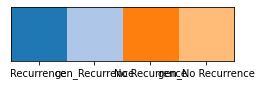

In [21]:
colours2 = sns.color_palette('tab20', 4)[:5]

ordered_labels_test = ('Recurrence','gen_Recurrence','No Recurrence','gen_No Recurrence')
label_colors_test = {lbl: c for lbl, c in zip(ordered_labels_test, colours2)}

sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

## Conditional Wasserstein GAN - GP model for binary / feature occurrence data

This model construction for the ususal CWGAN-GP was made by joining WGAN-GP models with Conditional GAN models. WGAN-GP models were originally made according to / originally based in https://keras.io/examples/generative/wgan_gp/#wasserstein-gan-wgan-with-gradient-penalty-gp and Conditional GAN models - https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ (generator and discriminator model) and https://keras.io/examples/generative/conditional_gan/ without using OOP (loss functions and training/training steps).

However, this time we have discrete data instead of continuous data. Thus, we have to perform alterations to our CWGAN-GP model. 

The strategy followed was suggested by Gulrajani et al. (https://arxiv.org/pdf/1704.00028.pdf). Since this data can have 2 values in each feature (0 or 1), the previous final dense layer generates two times the number of features in the data: 2 values for each feature, one representing 0 and the other 1. Then, they are passed to a softmax layer that for generates probabilities for each set of 2 values for each feature as the output of the generator. This output is directly given to the critic. When real data is passed to the critic, it is transformed to have this format (having 100% or 1 probability of having one of the values and 0% of having the other). The critic now receives this altered output, but the remaining architecture stays the same as before. After GAN training, samples are generated by the generator and, for each feature, the vector with 2 values is transformed to 1 or 0 depending on which had the highest probability.

In [22]:
# Import needed functions from GAN_functions
from GAN_functions import softmax
from GAN_functions import gradient_penalty_cwgan_bin
from GAN_functions import critic_loss_wgan
from GAN_functions import generator_loss_wgan

In [23]:
batch_size = 32

all_data = data_bin.iloc[np.random.RandomState(seed=145).permutation(len(data_bin))]
true_labels = pd.get_dummies(np.array(hd_labels)[np.random.RandomState(seed=145).permutation(len(data_bin))]).values[:,0]

In [24]:
def generator_model(len_input, len_output, n_labels, n_hidden_nodes): 
    "Make the generator model of CWGAN-GP-Binary."

    data_input = tf.keras.Input(shape=(len_input,), name='data') # Take feature occurrence input
    label_input = tf.keras.Input(shape=(1,), name='label') # Take Label Input

    # Treat label input to concatenate after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m2 = tf.keras.layers.Reshape((256,))(label_m)

    joined_data = tf.keras.layers.Concatenate()([data_input, label_m2]) # Concatenate the two inputs
    # Hidden Dense Layer and Normalization
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.BatchNormalization()(joined_data)
    
    # Output - number of features of sample to make with 2 values for each feature - one with a probability of the value being 0
    # and the other with a probaiblity of the value being 1.
    output = tf.keras.layers.Dense(len_output*2, activation='linear', use_bias=True)(joined_data)
    output = softmax(output, len_output) # Gives probability between the values 0 and 1 for each feature
    
    generator = tf.keras.Model(inputs=[data_input, label_input], outputs=output)
    
    return generator

In [25]:
def critic_model(len_input, n_labels, n_hidden_nodes):
    "Make the critic model of CWGAN-GP-Binary."
    
    label_input = tf.keras.Input(shape=(1,)) # Take Label Input
    data_input = tf.keras.Input(shape=(len_input,2,)) # Take input that has for each feature 2 values - one with a probability 
    # of the value being 0 and the other with a probaiblity of the value being 1.
    #data_input = tf.keras.layers.Reshape((len_input,1,))(data_input)
    
    # Treat label input to concatenate after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m = tf.keras.layers.Reshape((256,))(label_m)
    
    # Flatten the data
    data_m = tf.keras.layers.Reshape((len_input*2,))(data_input)
    
    joined_data = tf.keras.layers.Concatenate()([data_m, label_m]) # Concatenate feature occurrence and label data
    # Hidden Dense Layer (Normalization worsened results here)
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    #joined_data = tf.keras.layers.BatchNormalization()(joined_data)

    # Output Layer - 1 node for critic decision
    output = tf.keras.layers.Dense(1, activation='linear', use_bias=True)(joined_data)
    
    critic = tf.keras.Model(inputs=[data_input, label_input], outputs=output)

    return critic

In [26]:
# To save the models built
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [27]:
def generate_predictions(model, num_examples_to_generate, len_input, input_dist, uni_lbls):
    "Generate sample predictions based on a Generator model."
    
    test_input =  tf.constant(input_dist.rvs(size=len_input*num_examples_to_generate), shape=[
        num_examples_to_generate,len_input]) 
    
    if len(uni_lbls) < 3:
        test_labels = tf.constant([1.0]*(num_examples_to_generate//2) + [0.0]*(num_examples_to_generate//2), 
                                  shape=(num_examples_to_generate,1))
    else:
        test_labels = []
        for i in range(len(uni_lbls)):
            test_labels.extend([i]*(num_examples_to_generate//len(uni_lbls)))
        test_labels = np.array(pd.get_dummies(test_labels))
        #np.array(pd.get_dummies([i for i in range(len(uni_lbls))]*(num_examples_to_generate//len(uni_lbls))))

    predictions = model([test_input, test_labels], training=False) # `training` is set to False.
    return predictions

In [28]:
def training_montage(data, lbls, epochs, generator, critic, generator_optimizer, critic_optimizer, input_dist,
                    batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15):
    """Train a generator and critic of CWGAN-GP-Binary.
    
       Receives data and respective class labels data and lbls), divides it into training and test  data and trains a generator
    and a critic model (generator, critic) over a number of epochs (epochs) with a set batch size (batch_size)
    with the respective optimizers and learning rate (generator_optimizer, critic_optimizer). Gradient Penalty is
    calculated with grad_pen_weight as the weight of the penalty.
       The functions returns at time intervals three graphs to evaluate the progression of the models (Loss plots, coverage,
    density, crossLID and correct first cluster plots and PCA plot with generated and test data). To this end, samples need
    to be generated requiring the distribution to sample the initial input values from (input_dist). Finally the number of
    neighbors to consider for coverage/density and crossLID calculation is also needed (k_cov_den, k_crossLID).
    
       data: Pandas DataFrame with data;
       lbls: List with data class labels;
       epochs: Int value with the number of epochs to train the model;
       generator: tensorflow keras.engine.functional.Functional model for the generator;
       critic: tensorflow keras.engine.functional.Functional model for the critic;
       generator_optimizer: tensorflow keras optimizer (with learning rate) for generator;
       critic_optimizer: tensorflow keras optimizer (with learning rate) for critic;
       input_dist: scipy.stats._continuous_distns.rv_histogram object - distribution to sample input values for generator;
       batch_size: int value with size of batch for model training;
       grad_pen_weight: int value (default 10) for penalty weight in gradient penalty calculation;
       k_cov_den: int value (default 50) for number of neighbors to consider for coverage and density calculation in generated
    samples evaluation;
       k_crossLID: int value (default 15) for number of neighbors to consider for crossLID calculation in generated samples
    evaluation.
    """
    
    # Obtaining the train and test data from all_data, randomizing its order
    all_data = data.iloc[np.random.RandomState(seed=145).permutation(len(data))]
    
    # Divide data into training and test data
    test_data = all_data[-3*batch_size:].values
    training_data = all_data[:-3*batch_size]
    train_data = all_data[:-3*batch_size].values
    
    # Change class labels to numerical values while following the randomized ordered of samples
    if len(set(lbls)) < 3: # 1 and 0 for when there are only two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values[:,0]
    else: # One hot encoding for when there are more than two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values
    # Save the order of the labels
    ordered_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).columns

    test_labels = true_labels[-3*batch_size:]
    train_labels = true_labels[:-3*batch_size]#, shape=(len(all_data-3*batch_size,1))

    # To save the model after
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     critic_optimizer=critic_optimizer,
                                     generator=generator,
                                     critic=critic)

    half_batch = int(batch_size / 2) 
    batch_divisions = int(batch_size / len(set(lbls))) # See how many samples of each class will be in each batch
    n_steps = epochs * int(training_data.shape[0] / batch_size)
    n_critic = 5
    
    # Set up the evaluating images printed during training and the intervals they will be updated
    f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))
    update1 = n_steps//200
    update2 = n_steps//20

    if hasattr(tqdm, '_instances'):
        tqdm._instances.clear() # clear if it exists
        
    i=0

    for step in tqdm(range(n_steps)):
        
        # Critic Training
        crit_loss_temp = []
        
        # Select real samples for this batch on training and order samples to put samples of the same class together
        real_samp = train_data[i*batch_size:(i+1)*batch_size]
        real_lbls = train_labels[i*batch_size:(i+1)*batch_size]

        real_samp_2 = np.empty(real_samp.shape)
        real_labels = np.empty(real_lbls.shape)
        a = 0
        for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: pair[0], reverse=True):
            real_samp_2[a] = s
            real_labels[a] = l
            a = a+1
        
        #ones = np.count_nonzero(real_labels == 1)
        #zeros = np.count_nonzero(real_labels == 0)
        
        # Transform real samples to have for each feature two values (probability of the value being 0 or 1) to give as an
        # acceptable input to the critic. In this case the probability of being 0 or 1, since the values are already set are
        # 100% (1) or 0% (0)
        real_samples = tf.one_hot(tf.cast(real_samp_2, 'int32'), 2)
            
        for _ in range(n_critic):  # For each step, train critic n_critic times
            
            # Generate artificial samples as input for generator
            artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
            artificial_labels = real_labels.copy()
            
            artificial_samples = generator([artificial_samples, artificial_labels], training=True) # Get the artificial samples
            
            with tf.GradientTape() as crit_tape:

                # Get the logits for the generated samples
                X_artificial = critic([artificial_samples, artificial_labels], training=True)
                # Get the logits for the real samples
                X_true = critic([real_samples, real_labels], training=True)

                # Calculate the critic loss using the generated and real sample results
                c_cost = critic_loss_wgan(X_true, X_artificial)

                # Calculate the gradient penalty
                grad_pen = gradient_penalty_cwgan_bin(batch_size, real_samples, artificial_samples,
                                                      real_labels, artificial_labels, critic)
                # Add the gradient penalty to the original discriminator loss
                crit_loss = c_cost + grad_pen * grad_pen_weight
                #print(crit_loss)
                #crit_loss = c_cost
                
            crit_loss_temp.append(crit_loss)

            # Calculate and apply the gradients obtained from the loss on the trainable variables
            gradients_of_critic = crit_tape.gradient(crit_loss, critic.trainable_variables)
            #print(gradients_of_critic)
            critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
        
        crit_loss_all.append(np.mean(crit_loss_temp))

        i = i + 1
        if (step+1) % (n_steps//epochs) == 0:
            i=0
        
        # Generator Training
        # Generate inputs for generator, values and labels
        artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
        
        if len(set(lbls)) < 3:
            artificial_labels = tf.constant([1.0]*(batch_size//2) + [0.0]*(batch_size//2), shape=(batch_size,1))
        else:
            artificial_labels = np.array(pd.get_dummies([i for i in range(len(set(train_lbls)))]*batch_divisions))
        #artificial_labels = tf.constant([1.0]*half_batch + [0.0]*half_batch, shape=(batch_size,1))
        
        with tf.GradientTape() as gen_tape: # See the gradient for the generator
            # Generate artificial samples
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            # Get the critic results for generated samples
            X_artificial = critic([artificial_samples, artificial_labels], training=True)
            # Calculate the generator loss
            gen_loss = generator_loss_wgan(X_artificial)
        
        # Calculate and apply the gradients obtained from the loss on the trainable variables
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        #print(gradients_of_generator)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        gen_loss_all.append(gen_loss)

        # Update the progress bar and evaluation graphs every update1 steps for loss plots and update2 for the others.
        if (step + 1) % update1 == 0:
            
            # Update the evaluating figures at the set intervals
            axl.clear() # Always clear the corresponding ax before redrawing it
            
            # Loss Plot
            axl.plot(gen_loss_all, color = 'blue', label='Generator Loss')
            axl.plot(crit_loss_all,color = 'red', label='Critic Loss')
            axl.set_xlabel('Number of Steps')
            axl.set_ylabel('Loss')
            axl.legend()
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        if (step + 1) % update2 == 0:
            
            # 2 steps to generate samples: 1) apply the generator; 2) then choose if the value is 0 or 1 for each feature
            # based on the probabilities generated by the generator
            f_samp = generate_predictions(generator, 96, all_data.shape[1], input_realdata_dist, ordered_labels)
            f_samples = tf.argmax(f_samp, f_samp.get_shape().ndims-1)
            saved_predictions.append(f_samples)
            
            # See density and coverage and crossLID (divided by 50 to be in the same order as the rest) of latest predictions
            artificial_labels = tf.constant([1.0]*(96//2) + [0.0]*(96//2), shape=(96,1))
            den, cov = gem.evaluation_coverage_density(
                all_data[:-3*batch_size], saved_predictions[-1], k=k_cov_den, metric='jaccard')
            clid = gem.cross_LID_estimator_byMLE(
                all_data[:-3*batch_size], saved_predictions[-1], k=k_crossLID, metric='jaccard')/50
            density.append(den)
            coverage.append(cov)
            crossLID.append(clid)

            # PCA of the latest predictions and training data
            dfs_temp = pd.concat((training_data,pd.DataFrame(
                saved_predictions[-1].numpy(), columns=training_data.columns)))
            temp_lbls = list(np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))][:-3*batch_size]).copy()
            temp_lbls.extend(['gen_No Recurrence']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_Recurrence']*(len(saved_predictions[-1])//2))
            principaldf = gem.pca_sample_projection(dfs_temp, temp_lbls, pca, whiten=True, 
                                                samp_number=len(data.index))
            lcolors = label_colors_test

            # Hierarchical clustering of the latest predictions and testing data, 
            # saving the correct 1st cluster fraction results
            dfs_temp = np.concatenate((test_data, saved_predictions[-1].numpy()))
            temp_lbls = ['real']*len(test_data) + ['gen']*len(saved_predictions[-1])
            hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='average')
            corr1stcluster.append(hca_results['correct 1st clustering'])
            
            # Plots
            axc.clear()
            axc.plot(range(update2, step+2, update2), coverage, label='coverage')
            axc.plot(range(update2, step+2, update2), density, label='density')
            axc.plot(range(update2, step+2, update2), crossLID, color='red', label='crossLID')
            axc.plot(range(update2, step+2, update2), corr1stcluster, color='purple', label='corr_cluster')
            axc.legend()

            axr.clear()
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
            axr.legend(loc='upper right', ncol=1, framealpha=1)
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
        # Save the model every so often
        if (step + 1) % (update2*5) == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)      

In [29]:
df = data_bin
pca = PCA(n_components=2, svd_solver='full', whiten=True)
pc_coords = pca.fit_transform(df)

### Training the GAN

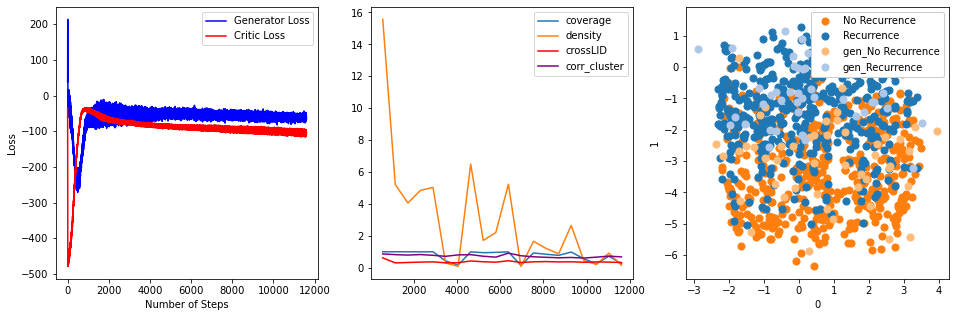

100%|██████████████████████████████████████████████████████████████████████████| 11600/11600 [1:22:52<00:00,  2.33it/s]


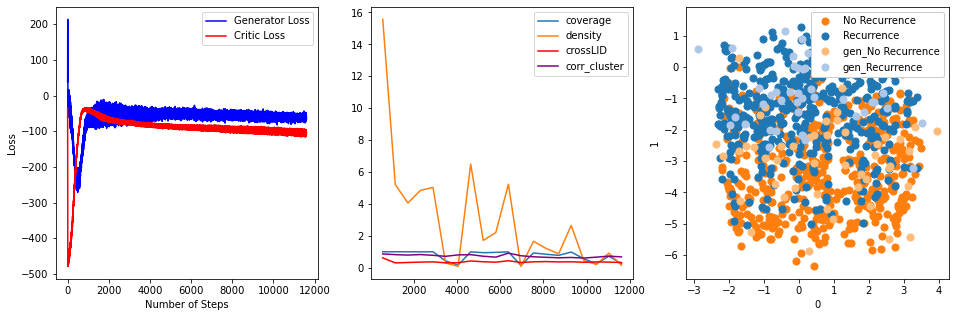

In [30]:
# Store results
gen_loss_all = []
crit_loss_all = []
saved_predictions = []
coverage = []
density = []
crossLID = []
corr1stcluster = []

GENERATE = True
if GENERATE:
    generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

    generator = generator_model(data_bin_gen.shape[1], data_bin_gen.shape[1], 2, 256)
    critic = critic_model(data_bin_gen.shape[1], 2, 512)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_bin_gen, lbls, 400, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=5, k_cov_den=20, k_crossLID=15)

    #    results[i]={'gen_loss': gen_loss_all, 'crit_loss1': crit_loss1_all, 'crit_loss2': crit_loss2_all,
    #                'saved_pred': saved_predictions, 'accuracy': accuracy,
    #                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [31]:
#GENERATE=False
if GENERATE:
    # Save the generator and critic models' weights.
    generator.save_weights('gan_models/HD_gen_bin')
    critic.save_weights('gan_models/HD_crit_bin')
else:
    # Read back the saved model
    generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

    generator = generator_model(data_bin_gen.shape[1], data_bin_gen.shape[1], 2, 256)
    critic = critic_model(data_bin_gen.shape[1], 2, 512)

    # Load Previously saved models
    generator.load_weights('./gan_models/HD_gen_bin')
    critic.load_weights('./gan_models/HD_crit_bin')

#### Generate examples from our new code

- Generate examples in bulk - predictions (GAN data)
- Select only the 5 most correlated generated samples with each of the original samples - corr_preds (CorrGAN Data)

In [32]:
num_examples_to_generate = 2048
test_input = tf.constant(input_realdata_dist.rvs(size=len(data_bin_gen.columns)*num_examples_to_generate), 
                         shape=[num_examples_to_generate,len(data_bin_gen.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)
predictions = tf.argmax(predictions, predictions.get_shape().ndims-1) # Select the highest probability between the 0 or 1 value
# for each feature
predictions = pd.DataFrame(predictions.numpy(), columns=data_bin_gen.columns)

test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,])

See correlation between samples and choose the 5 most correlated generated samples for each of the original samples.

In [33]:
df = data_bin
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=predictions.index, columns=df.index).astype('float')

for i in df.index:
    for j in predictions.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               predictions.loc[j])[0]

In [34]:
# Indices to keep in the correlated GAN data
idx_to_keep = []
for i in correlations:
    idx_to_keep.extend(correlations[i].sort_values(ascending=False).index[:5])
    
print('Nº of total idx :', len(idx_to_keep))
print('Nº of unique idx:', len(set(idx_to_keep)))

Nº of total idx : 1245
Nº of unique idx: 455


In [35]:
# Make the correlation GAN dataframe and corresponding label targets
corr_preds = predictions.loc[list(set(idx_to_keep))]
corr_lbls  = list(np.array(
    ['gen_No Recurrence']*(len(predictions)//2) + ['gen_Recurrence']*(len(predictions)//2))[list(set(idx_to_keep))])

In [36]:
num_examples_to_generate = 1024
test_input = tf.constant(input_realdata_dist.rvs(size=len(data_bin_gen.columns)*num_examples_to_generate),
                         shape=[num_examples_to_generate, len(data_bin_gen.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)
predictions = tf.argmax(predictions, predictions.get_shape().ndims-1)
predictions = pd.DataFrame(predictions.numpy(), columns=data_bin_gen.columns)

### Inducing noise on Feature Occurrence Data Method Sample Generation

In [37]:
# Inducing noise on linearly interpolated feature occurrence data
noise_df = data_bin_gen.copy()
for i in tqdm(range(len(data_bin_gen.index))):
    if lbls[i] == 'Recurrence':
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin_gen.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=False,
            data = data_bin.loc[np.array(hd_labels)=='Recurrence'])
    else:
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin_gen.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=False,
            data = data_bin.loc[np.array(hd_labels)=='No Recurrence'])
        
int_noise_df = noise_df
int_noise_lbls = lbls.copy()

100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:21<00:00, 47.39it/s]


### Loss Plot and PCAs and tSNEs representation on the evolution of generated samples with epochs

Measures of progression of the model in time.

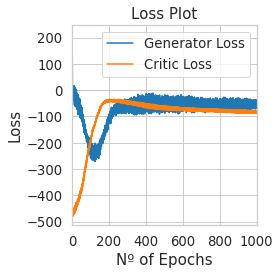

In [38]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        steps_per_epoch = int((data_bin.shape[0]-96) / 32)
        f, ax = plt.subplots(1, 1, figsize=(4,4))
        ax.plot(range(1,len(gen_loss_all)+1), gen_loss_all, label='Generator Loss')
        ax.plot(range(1,len(crit_loss_all)+1), crit_loss_all, label='Critic Loss')
        ax.set_xticks(range(0, 1001*steps_per_epoch, 200*steps_per_epoch))
        ax.set_xticklabels(range(0, 1001, 200))

        ax.legend()
        ax.set_xlim([0*steps_per_epoch,1000*steps_per_epoch])
        ax.set_xlabel('Nº of Epochs', fontsize=15)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_title('Loss Plot', fontsize=15)
        plt.tight_layout()
        f.savefig('images/HDbin_LossPlot.png' , dpi=300)

In [39]:
#saved_predictions = []

#num_examples_to_generate = 96
#test_input = tf.constant(input_realdata_dist.rvs(size=len(data_bin_gen.columns)*num_examples_to_generate), 
#                         shape=[num_examples_to_generate,len(data_bin_gen.columns)])
#tl = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
#        num_examples_to_generate,1])

#p = generator([test_input, tl], training=False)
#p = tf.argmax(p, p.get_shape().ndims-1) # Select the highest probability between the 0 or 1 value
# for each feature
#saved_predictions.append(pd.DataFrame(p.numpy(), columns=data_bin_gen.columns))

In [40]:
# Transform predictions into Pandas DataFrames
for i in range(len(saved_predictions)):
    saved_predictions[i] = pd.DataFrame(saved_predictions[i].numpy(), columns=data_bin.columns)

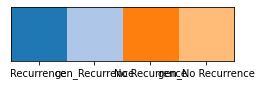

In [41]:
sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

**PCA and tSNE of GAN generated data and the linearly generated 'test data'**

Progression with number of epochs.

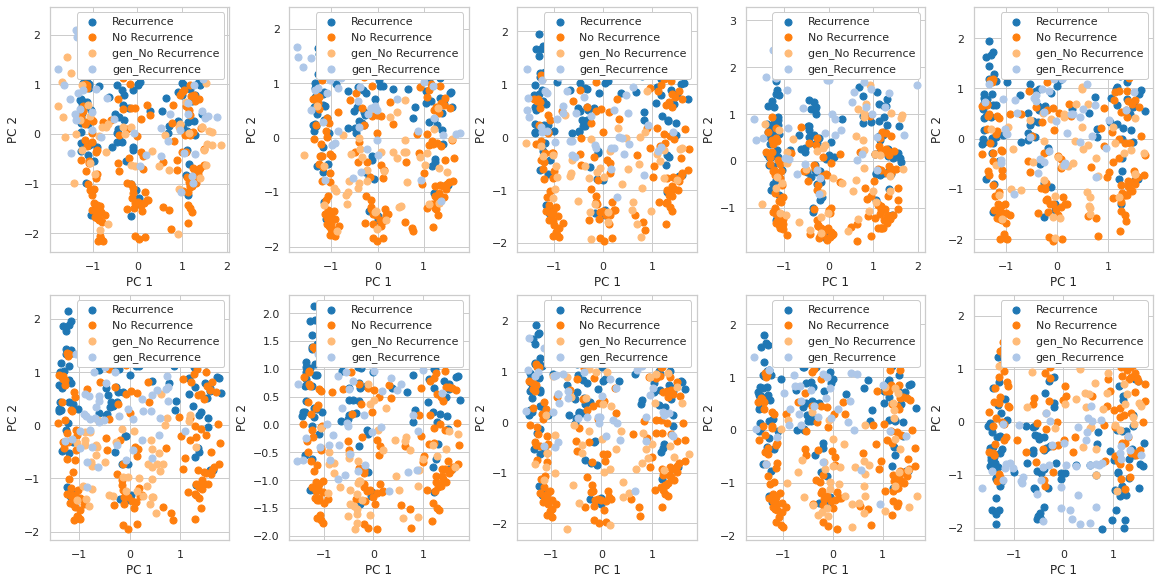

In [42]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions),2), axs.ravel()):
            dfs_temp = pd.concat((data_bin,saved_predictions[i]))
            temp_lbls = hd_labels.copy()
            temp_lbls.extend(['gen_No Recurrence']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_Recurrence']*(len(saved_predictions[-1])//2))
            
            principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

            lcolors = label_colors_test
            
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            #plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
        

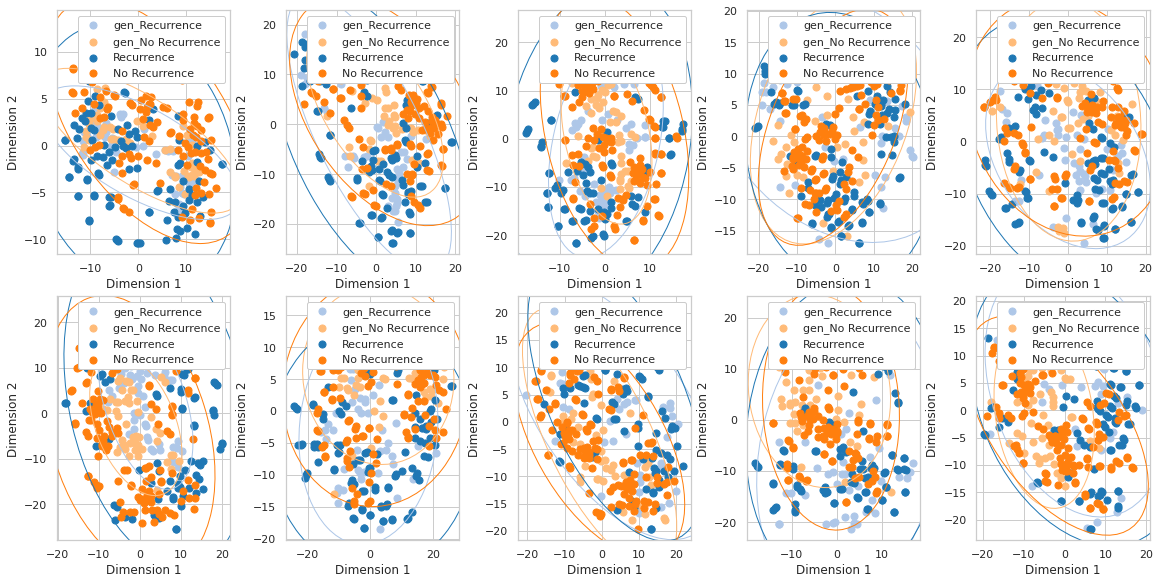

In [43]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions), 2), axs.ravel()):
            
            dfs_temp = pd.concat((data_bin,saved_predictions[i]))
            temp_lbls = hd_labels.copy()
            temp_lbls.extend(['gen_No Recurrence']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_Recurrence']*(len(saved_predictions[-1])//2))
            
            X = dfs_temp.copy()
            X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                              init='random', verbose=0).fit_transform(X)

            df = X_embedded
            labels = temp_lbls
            lcolors = label_colors_test
            
            gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=ax)
            gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)

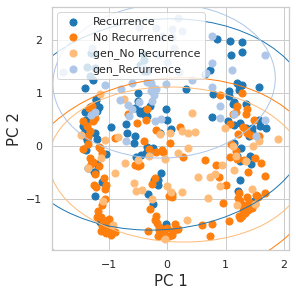

In [44]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
            
        p = saved_predictions[-1].copy()
        p.columns = data_bin.columns
        dfs_temp = pd.concat((data_bin,p))
        temp_lbls = hd_labels.copy()
        temp_lbls.extend(['gen_No Recurrence']*(len(saved_predictions[-1])//2))
        temp_lbls.extend(['gen_Recurrence']*(len(saved_predictions[-1])//2))
    
        principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

        lcolors = label_colors_test

        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
        ax.set_ylabel('PC 2', fontsize=15)
        ax.set_xlabel('PC 1', fontsize=15)
        ax.legend(loc='upper left', ncol=1, framealpha=0.8)
        f.savefig('images/HDbin_PCAPlot.png' , dpi=300)

### Comparing GAN Generated Data Characteristics with other data

In [45]:
names = ['Real data', 'GAN data', 'CorrGAN data', 'Noise I. data']
data_repo = [data_bin, predictions, corr_preds, int_noise_df]
tgs = [hd_labels,  ['gen_No Recurrence']*(len(predictions)//2) + ['gen_Recurrence']*(len(predictions)//2),
       corr_lbls, int_noise_lbls]
data_characteristics = [gem.characterize_binary_data(ds, name, tg) for ds,name,tg in zip(data_repo, names, tgs)]

data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,average # of features per sample (std),# features per sample ranges,# features per sample median,average # of times feature appear in sample (std),min and max # of times a feature appears in a sample,# classes,samples / class
Dataset,,,,,,,,,
Real data,249,12869,7936.33 (268.47),(7057.0 - 8475.0),7960.0,153.56 (91.71),2.0 - 249.0,2,124.5
GAN data,1024,12869,7823.53 (250.23),(6164 - 8388),7847.5,622.53 (354.35),0 - 1024,2,512.0
CorrGAN data,455,12869,7890.85 (228.52),(7057 - 8389),7915.0,278.99 (163.18),0 - 455,2,227.5
Noise I. data,1024,12869,7926.42 (217.13),(7209.0 - 8429.0),7944.0,630.71 (297.58),85.0 - 980.0,2,512.0


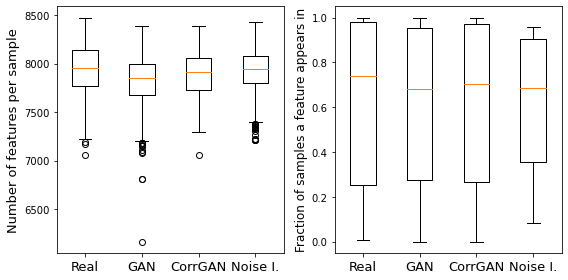

In [46]:
f, (axl, axr) = plt.subplots(1,2, figsize=(8,4))

names = ['Real', 'GAN', 'CorrGAN', 'Noise I.']
axl.boxplot([ds.sum(axis=1) for ds in data_repo])
axl.set_ylabel('Number of features per sample', fontsize=13)
axl.set_xticklabels(names, fontsize=13)
#axl.set_yticks([-2, 0, 2, 4])

axr.boxplot([ds.sum(axis=0)/len(ds) for ds in data_repo])
axr.set_ylabel('Fraction of samples a feature appears in', fontsize=12)
axr.set_xticklabels(names, fontsize=13)

plt.tight_layout()
plt.show()
f.savefig('images/HDbin_characteristics.png' , dpi=300)

### Hierarchical Clustering

Hierarchical clustering of the latest predictions and testing data (96 random samples from real data). 

In [47]:
# Hierarchical clustering of the latest predictions and 96 samples from real data, 
# saving the correct 1st cluster fraction results
dt = data_bin
t_data = dt.iloc[np.random.RandomState(seed=145).permutation(len(dt))][-96:]
dfs_temp = np.concatenate((t_data, saved_predictions[-1].values))
tl = np.array(hd_labels)[np.random.RandomState(seed=145).permutation(len(dt))][-96:]
temp_lbls = list(tl) + ['gen_No Recurrence']*(len(saved_predictions[-1])//2) + [
    'gen_Recurrence']*(len(saved_predictions[-1])//2)

hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='ward')

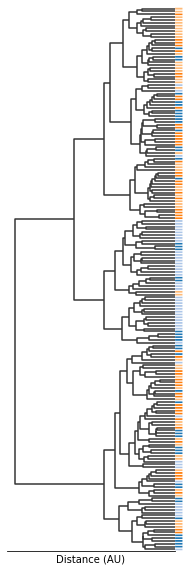

In [48]:
f, ax = plt.subplots(figsize=(3, 10))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)
ax.set_yticklabels([])
ax.set_xticks([])
plt.show()
f.savefig('images/HDbin_HCAPlot.png' , dpi=300)

In [53]:
# Hierarchical clustering of the corrGAN data and real data, 
# saving the correct 1st cluster fraction results
dfs_temp = np.concatenate((t_data, corr_preds.values))
test_labels = np.array(hd_labels)[np.random.RandomState(seed=145).permutation(len(data_bin))][-96:]
temp_lbls = list(test_labels) + corr_lbls

hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='ward')

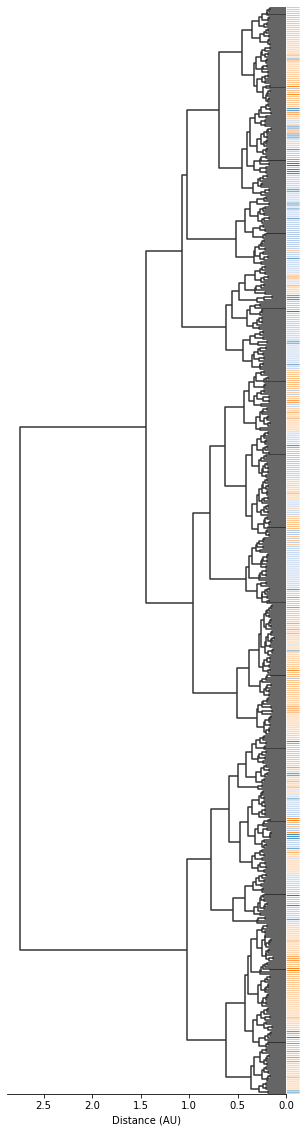

In [52]:
f, ax = plt.subplots(figsize=(5, 20))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)
ax.set_yticklabels([])
plt.show()

### Coverage and Density

In [54]:
#training_set = tf.constant(all_data[:-3*batch_size])

density_list, coverage_list = gem.evaluation_coverage_density_all_k_at_once(data_bin, predictions, 
                                                                            metric='jaccard')

corr_density_list, corr_coverage_list = gem.evaluation_coverage_density_all_k_at_once(data_bin, corr_preds, 
                                                                            metric='jaccard')

lin_density_list, lin_coverage_list = gem.evaluation_coverage_density_all_k_at_once(data_bin, data_bin_gen, 
                                                                            metric='jaccard')

density_list_noise, coverage_list_noise = gem.evaluation_coverage_density_all_k_at_once(data_bin, 
                                                                                      int_noise_df,
                                                                                      metric='jaccard')

lin_density_list2, lin_coverage_list2 = gem.evaluation_coverage_density_all_k_at_once(data_bin_gen, predictions,
                                                                            metric='jaccard')

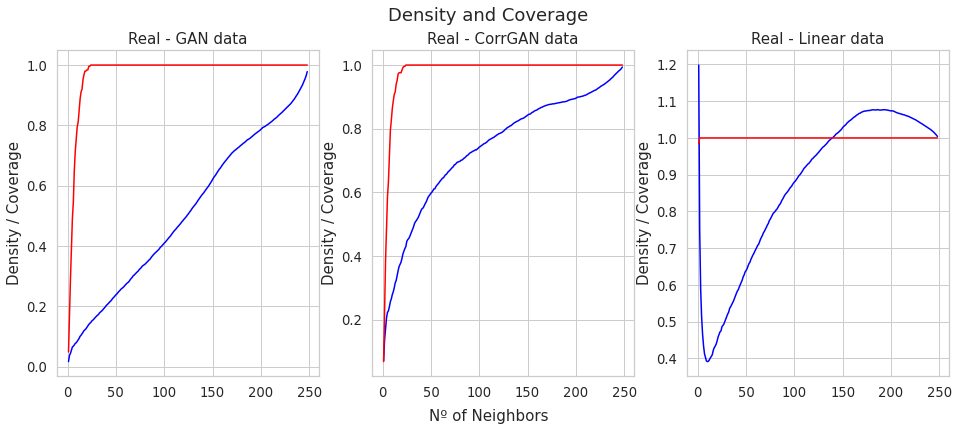

In [55]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(data_bin)), density_list, label='Density', color='blue')
        axl.plot(range(1,len(data_bin)), coverage_list, label='Coverage', color='red')
        axl.set_title('Real - GAN data', fontsize=15)
        axl.set_ylabel('Density / Coverage', fontsize=15)
        #axl.set_ylim([0,1.5])
        
        axc.plot(range(1,len(data_bin)), corr_density_list, label='Density', color='blue')
        axc.plot(range(1,len(data_bin)), corr_coverage_list, label='Coverage', color='red')
        axc.set_title('Real - CorrGAN data', fontsize=15)
        axc.set_ylabel('Density / Coverage', fontsize=15)
        #axcl.set_ylim([0,1.5])
        
        axr.plot(range(1,len(data_bin)), lin_density_list, label='Density', color='blue')
        axr.plot(range(1,len(data_bin)), lin_coverage_list, label='Coverage', color='red')
        axr.set_title('Real - Linear data', fontsize=15)
        axr.set_ylabel('Density / Coverage', fontsize=15)
        #axr.set_ylim([0,1.5])
        
        plt.suptitle('Density and Coverage', fontsize=18)

    f.text(0.5, 0.05, 'Nº of Neighbors', ha='center', va='top', fontsize=15)

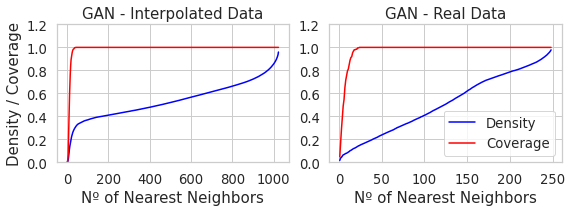

In [56]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (8,3))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(data_bin_gen)), lin_density_list2, label='Density', color='blue')
        axl.plot(range(1,len(data_bin_gen)), lin_coverage_list2, label='Coverage', color='red')
        axl.set_title('GAN - Interpolated Data', fontsize=15)
        axl.set_ylabel('Density / Coverage', fontsize=15)
        axl.set_ylim([0,1.2])
        axl.set_xlabel('Nº of Nearest Neighbors', fontsize=15)

        axr.plot(range(1,len(data_bin)), density_list, label='Density', color='blue')
        axr.plot(range(1,len(data_bin)), coverage_list, label='Coverage', color='red')
        axr.set_title('GAN - Real Data', fontsize=15)
        axr.set_ylim([0,1.2])
        
        axr.legend()
        axr.set_xlabel('Nº of Nearest Neighbors', fontsize=15)
        #plt.suptitle('Density and Coverage', fontsize=18)

    plt.tight_layout()
    f.savefig('images/HDbin_DenCovPlot.png' , dpi=300)

### CrossLID (Local Intrinsic Dimensionality) Evaluation

In [57]:
#training_set = tf.constant(all_data[:-3*batch_size])
CrossLIDs = {}

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(data_bin, predictions, 
                                                metric='jaccard')
CrossLIDs['RealVGAN'] = c_lid
print('Real - GAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(data_bin, corr_preds, 
                                                metric='jaccard')
CrossLIDs['RealVCorr'] = c_lid
print('Real - CorrGAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(data_bin, data_bin_gen, 
                                                metric='jaccard')
CrossLIDs['RealVLin'] = c_lid
print('Real - Linear Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(data_bin,
                                                    int_noise_df,
                                                    metric='jaccard')
CrossLIDs['RealVNoise'] = c_lid
print('Real - Noise Done')

Real - GAN Done
Real - CorrGAN Done
Real - Linear Done
Real - Noise Done


In [58]:
LIDs = {}

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(predictions, metric='jaccard')
LIDs['GAN'] = lid
print('GAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(corr_preds, metric='jaccard')
LIDs['CorrGAN'] = lid
print('Correlated GAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(data_bin_gen, metric='jaccard')
LIDs['Linear'] = lid
print('Linear Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(data_bin, metric='jaccard')
LIDs['Real'] = lid
print('Real Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(int_noise_df, metric='jaccard')
LIDs['Noise'] = lid
print('Noise Data Done')

GAN Data Done
Correlated GAN Data Done
Linear Data Done
Real Data Done
Noise Data Done


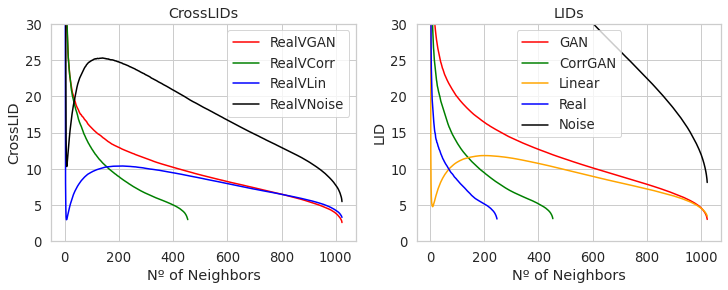

In [59]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(12,4))
        c = {'LinearVGAN': 'Orange', 'RealVGAN': 'Red', 'RealVLin': 'Blue', 'RealVCorr': 'Green', 'RealVNoise': 'black'}
        for l, data in CrossLIDs.items():
            axl.plot(range(2,len(data)+2), data, label=l, color = c[l])
            
        axl.set_ylim([0,30])
        axl.legend()
        axl.set(xlabel='Nº of Neighbors', ylabel='CrossLID', title='CrossLIDs')
        
        c = {'GAN': 'Red', 'Linear': 'Orange', 'Real': 'Blue', 'CorrGAN': 'Green', 'Noise': 'black'}
        for l, data in LIDs.items():
            axr.plot(range(2,len(data)+2), data, label=l, color = c[l])
            
        axr.set_ylim([0,30])
        axr.legend()
        axr.set(xlabel='Nº of Neighbors', ylabel='LID', title='LIDs')

### Histograms
 
Histograms of Values of normal Real, Generated and GAN Generated Data.

In [60]:
last_preds = predictions

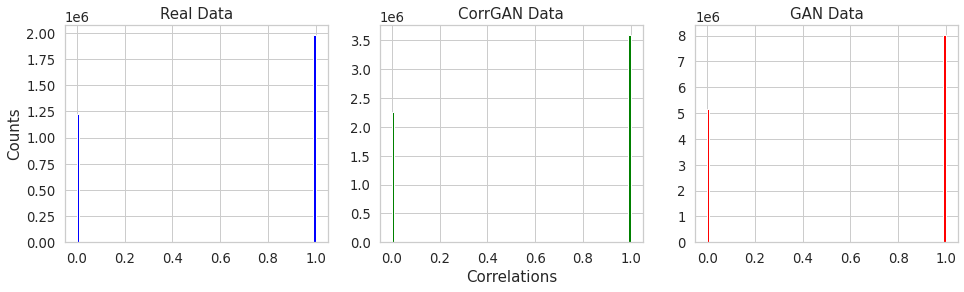

In [61]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,4))#, sharey='row')#, sharex='col')
        
        n_bins = 34
        axl.hist(data_bin.values.flatten(), bins=100, color='blue')
        axl.set_title('Real Data', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        
        axc.hist(corr_preds.values.flatten(), bins=100, color='green')
        axc.set_title('CorrGAN Data', fontsize=15)
        axc.set_xlabel('Correlations', fontsize=15)
        
        axr.hist(last_preds.values.flatten(), bins=100, color='red')
        axr.set_title('GAN Data', fontsize=15)

### Correlations between samples of Real Data and GAN Generated Data

In [62]:
correlation_real_real = gem.create_sample_correlations(data_bin, data_bin,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_real_gan = gem.create_sample_correlations(data_bin_gen, data_bin_gen,
                                                   method='pearson')
print('Correlation Real-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds, corr_preds,
                                                   method='pearson')
print('Correlation CorrGAN-CorrGAN calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(last_preds, last_preds,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_noise_noise = gem.create_sample_correlations(int_noise_df, int_noise_df,
                                                   method='pearson')
print('Correlation Noise-Noise calculation ended.')

Correlation Real-Real calculation ended.
Correlation Real-GAN calculation ended.
Correlation CorrGAN-CorrGAN calculation ended.
Correlation GAN-GAN calculation ended.
Correlation Noise-Noise calculation ended.


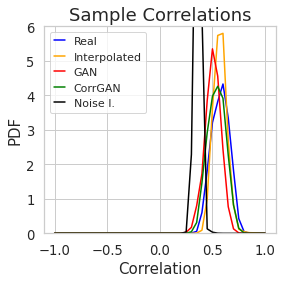

In [63]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (4,4))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_real_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Interpolated')
        
        hist = np.histogram(correlation_gan_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN')
        
        hist = np.histogram(correlation_noise_noise.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='black', label='Noise I.')
        
        ax.legend(handlelength=1, fontsize=11)
        ax.set_title('Sample Correlations', fontsize=18)
        ax.set_xlabel('Correlation', fontsize=15)
        ax.set_ylim([0,6])

    #f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)
    plt.tight_layout()
    f.savefig('images/HDbin_SampCorrPlot.png', dpi=300)

### Correlations between features of Real, Generated and GAN Generated Samples

In [74]:
%%capture --no-stdout
# Capture warnings on this cell

correlation_real_real = gem.create_sample_correlations(data_bin.T, data_bin.T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(last_preds.T, last_preds.T,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds.T, corr_preds.T,
                                                   method='pearson')
print('Correlation CorrGAN-CorrGAN calculation ended.')

correlation_noise_noise = gem.create_sample_correlations(int_noise_df.T, int_noise_df.T,
                                                   method='pearson')
print('Correlation Noise-Noise calculation ended.')

correlation_lin_lin = gem.create_sample_correlations(data_bin_gen.T, data_bin_gen.T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

Correlation Real-Real calculation ended.
Correlation GAN-GAN calculation ended.
Correlation CorrGAN-CorrGAN calculation ended.
Correlation Noise-Noise calculation ended.
Correlation Real-Real calculation ended.


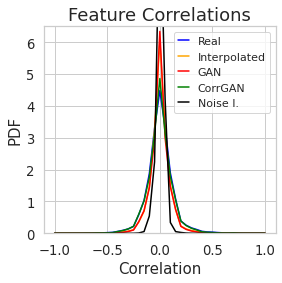

In [46]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (4,4))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_gen_gen.values.flatten()[~np.isnan(correlation_gen_gen.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_lin_lin.values.flatten()[~np.isnan(correlation_lin_lin.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Interpolated')
        
        hist = np.histogram(correlation_gan_gan.values.flatten()[~np.isnan(correlation_gan_gan.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten()[~np.isnan(correlation_corr_corr.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN')
        
        hist = np.histogram(correlation_noise_noise.values.flatten()[~np.isnan(correlation_noise_noise.values.flatten())],
                            bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='black', label='Noise I.')
        
        ax.legend(handlelength=1, fontsize=11)
        ax.set_title('Feature Correlations', fontsize=18)
        ax.set_xlabel('Correlation', fontsize=15)
        ax.set_ylim([0,6.5])

    #f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)
    plt.tight_layout()
    f.savefig('images/HDbin_FeatCorrPlot.png', dpi=300)

### Profiles of features appearing in vinifera or wild samples

In [63]:
GAN_data = saved_predictions[-1]
GAN_lbls = ['No Recurrence']*48 + ['Recurrence']*48
#GAN_lbls

In [64]:
vinifera_counts_GAN = []
wild_counts_GAN = []
for i in GAN_data.columns:
    vinifera_counts_GAN.append(GAN_data[i].iloc[:48].sum())
    wild_counts_GAN.append(- GAN_data[i].iloc[48:].sum())
    
#wild_counts_GAN

In [65]:
vinifera_counts_real = []
wild_counts_real = []
for i in data_bin.columns:
    vinifera_counts_real.append(data_bin[i].iloc[:114].sum())
    wild_counts_real.append(- data_bin[i].iloc[114:].sum())
    
#wild_counts_linear 

Making bar plots representing the number of samples of each class each feature appears in (kinda of a profile of the dataset)

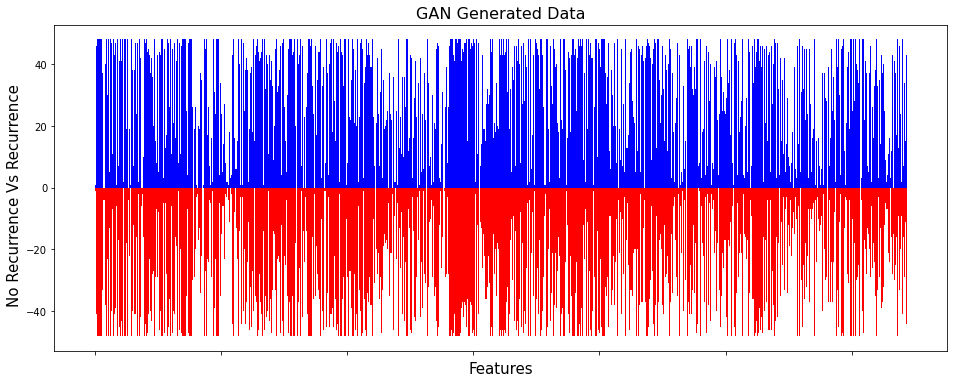

In [66]:
f, ax = plt.subplots(1, 1, figsize=(16, 6))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_GAN, width=1, color='r')
ax.bar(x, vinifera_counts_GAN, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('No Recurrence Vs Recurrence   ', fontsize=15)
ax.set_title('GAN Generated Data', fontsize=16)

plt.show()

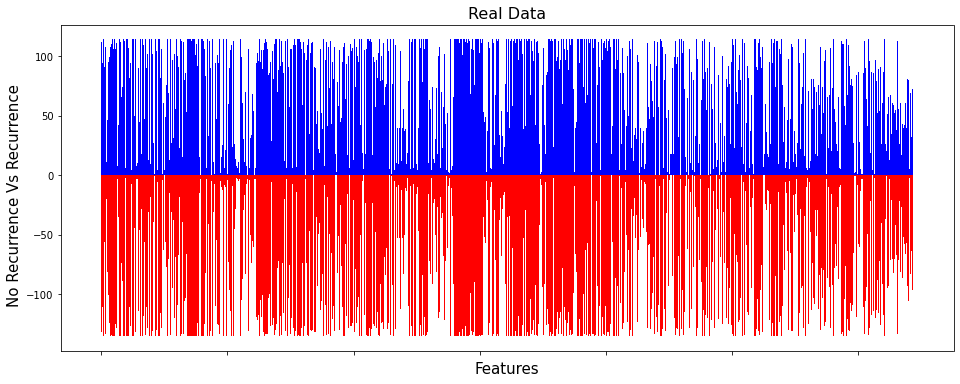

In [67]:
f, ax = plt.subplots(1, 1, figsize=(16, 6))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_real, width=1, color='r')
ax.bar(x, vinifera_counts_real, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('No Recurrence Vs Recurrence   ', fontsize=15)
ax.set_title('Real Data', fontsize=16)

plt.show()

### Sample Correlation Matrix

Between samples of the real data and a set of generated artificial samples of GANs

In [64]:
# Real Data, organize it to have first all samples of a class, then all samples of the other class
df = data_bin.copy()

samp = df.index
tg = hd_labels.copy()
new_order = [x for _, x in sorted(zip(tg, samp))]
new_tg = [x for x, _ in sorted(zip(tg, samp))]

df = df.loc[new_order]
#df

In [65]:
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=last_preds.index, columns=df.index).astype('float')

for i in df.index:
    for j in last_preds.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               last_preds.loc[j])[0]
        
correlations.columns = new_tg
correlations.index = ['gen_No Recurrence']*(len(last_preds)//2) + ['gen_Recurrence']*(len(last_preds)//2)

C:\Users\franc\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


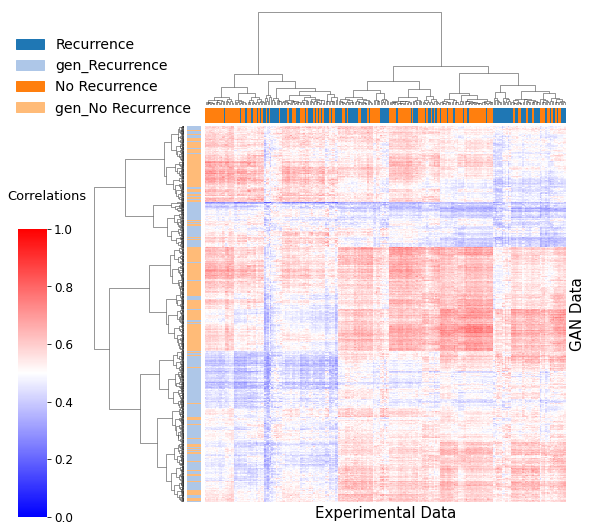

In [66]:
# Draw the clustermap
import matplotlib.patches as mpatches

row_cols = [label_colors_test[lbl] for lbl in new_tg]
row_cols2 = [label_colors_test[lbl] for lbl in correlations.index]
g = sns.clustermap(correlations, col_colors=row_cols, cmap='bwr', row_colors= row_cols2, vmin=0, vmax=1, method='ward',
                  cbar_pos = (-0.11, 0.1, 0.05, 0.5))
g.fig.set_size_inches((8,8))
# some tweaks
patches = []
for lbl in ordered_labels_test:
    patches.append(mpatches.Patch(color=label_colors_test[lbl], label=lbl))
leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.5, 1.35, 0.5, 1),
                     frameon=False, fontsize=14) 
g.ax_heatmap.set_ylabel('GAN Data', fontsize=15)
g.ax_heatmap.set_xlabel('Experimental Data', fontsize=15)
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, labelright=False)

# Manually specify colorbar labelling after it's been generated
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12) 
plt.text(1, 1.10, 'Correlations', fontsize=13, horizontalalignment='center')
#g.savefig('clustermap_Tryp.png' , dpi=300)
plt.show()
g.savefig('images/HDbin_Clustermap.png', dpi=300)

### CAS (Classification Accuracy Score)

In [67]:
# Test data - Linearly Generated Data (the same samples left as in the training of the model as test samples)
t_data = data_bin_gen.iloc[np.random.RandomState(seed=145).permutation(len(data_bin_gen))][-96:]
t_labels = np.array(lbls)[np.random.RandomState(seed=145).permutation(len(data_bin_gen))][-96:]

# Experimental Real Data
r_data = data_bin
r_labels = hd_labels

Random Forest Tests

In [68]:
top_tree_in_grid=300

# Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,top_tree_in_grid,5)}
rf = skensemble.RandomForestClassifier(n_estimators=100)
clf = GridSearchCV(rf, values, cv=5)

# GAN Data
clf.fit(predictions, [1]*(len(predictions)//2) + [0]*(len(predictions)//2))
GAN_param = clf.cv_results_['param_n_estimators']
GAN_test_score = clf.cv_results_['mean_test_score']

#CorrGAN data
clf.fit(corr_preds, corr_lbls)
corr_param = clf.cv_results_['param_n_estimators']
corr_test_score = clf.cv_results_['mean_test_score']

#Noise data
clf.fit(int_noise_df, int_noise_lbls)
noise_param = clf.cv_results_['param_n_estimators']
noise_test_score = clf.cv_results_['mean_test_score']

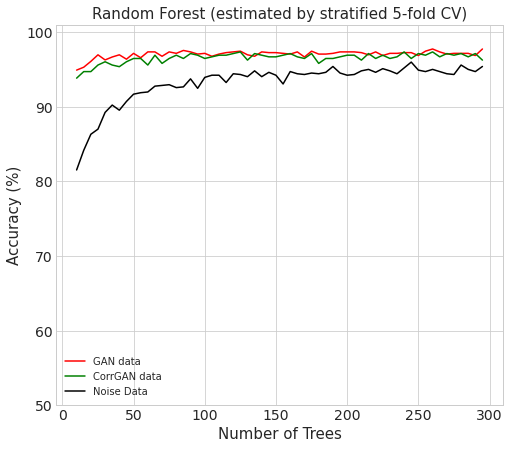

In [69]:
# Plotting the results and adjusting parameters of the plot
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots(figsize=(8,7))

    plt.plot(GAN_param, GAN_test_score*100, color='red', label='GAN data')
    plt.plot(corr_param, corr_test_score*100, color='green', label='CorrGAN data')
    plt.plot(noise_param, noise_test_score*100, color='black', label='Noise Data')

    plt.ylabel('Accuracy (%)', fontsize = 15)
    plt.xlabel('Number of Trees', fontsize = 15)
    plt.ylim(50,101)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Random Forest (estimated by stratified 5-fold CV)', fontsize=15)
    plt.legend()

In [70]:
# Fitting the model Generated samples
rf_mod = ma.RF_model(predictions, ['No Recurrence']*(len(predictions)//2) + ['Recurrence']*(len(predictions)//2), 
                     return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)
print('Classifier from GAN Generated Data Performance in predicting other samples:')

# Test data - Linearly Generated Data
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Test data - Experimental Real Data
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 91.66666666666666 %.
Predicting Experimental Data 85.14056224899599 %.


In [71]:
# Fitting the model Correlated Generated samples
rf_mod = ma.RF_model(corr_preds, [i[4:] for i in list(corr_lbls)], 
                     return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)
print('Classifier from Correlated GAN Generated Data Performance in predicting other samples:')

# Test data - Linearly Generated Data
print('Predicting Linearly Generated  Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Test data - Experimental Real Data
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from Correlated GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated  Data 84.375 %.
Predicting Experimental Data 81.92771084337349 %.


In [72]:
# Fitting the model Induced Noise samples
rf_mod = ma.RF_model(int_noise_df, int_noise_lbls, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)

# Testing the linearly generated test data
print('Classifier from Noise Induced and Intensity Imputed Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Testing the real data
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from Noise Induced and Intensity Imputed Data Performance in predicting other samples:
Predicting Linearly Generated Data 98.95833333333334 %.
Predicting Experimental Data 89.5582329317269 %.


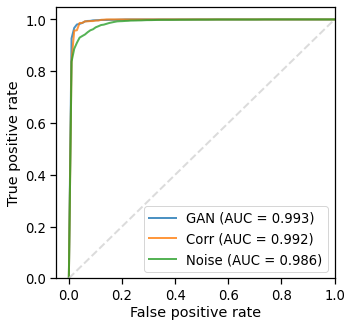

In [73]:
res_roc = {} 
res_roc['GAN'] = ma.RF_ROC_cv(predictions, ['No Recurrence']*(len(predictions)//2) + ['Recurrence']*(len(predictions)//2), 
                   'Recurrence', n_fold=5, n_trees=200, n_iter=5)

res_roc['Corr'] = ma.RF_ROC_cv(corr_preds, [i[4:] for i in list(corr_lbls)], 'Recurrence', n_fold=5, n_trees=200, n_iter=5)
res_roc['Noise'] = ma.RF_ROC_cv(int_noise_df, int_noise_lbls, 'Recurrence', n_fold=5, n_trees=200, n_iter=5)

with sns.plotting_context("notebook", font_scale=1.2):
    f, ax = plt.subplots(1, 1, figsize=(5,5))
    for name, res in res_roc.items():
        mean_fpr = res['average fpr']
        mean_tpr = res['average tpr']
        mean_auc = res['mean AUC']
        ax.plot(mean_fpr, mean_tpr,
               label=f'{name} (AUC = {mean_auc:.3f})',
               lw=2, alpha=0.8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
    ax.legend()
    ax.set_xlim(None,1)
    ax.set_ylim(0,None)
    ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
          # title="Random forest ROC curves for Vitis types data set")
    plt.show()

PLS-DA Tests

In [75]:
def decision_rule(y_pred, y_true):
    # Decision rule for classification
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
        else:
            pred = 0
        if pred == y_true[p]:
            nright += 1  # Correct prediction


    # Calculate accuracy for this iteration
    accuracy = (nright / len(y_pred))
    return accuracy

In [76]:
%%capture --no-stdout
# Capture warnings on this cell

GAN_optim_pls = ma.optim_PLSDA_n_components(predictions, pd.get_dummies(['No Recurrence']*(len(predictions)//2) + [
    'Recurrence']*(len(predictions)//2)).values[:,0], encode2as1vector=True, max_comp=8, n_fold=5).CVscores
corr_optim_pls = ma.optim_PLSDA_n_components(corr_preds, pd.get_dummies([i[4:] for i in list(corr_lbls)]).values[:,0], 
                                         encode2as1vector=True, max_comp=8, n_fold=5).CVscores
noise_optim_pls = ma.optim_PLSDA_n_components(int_noise_df, int_noise_lbls,
                                              encode2as1vector=True, max_comp=8, n_fold=5).CVscores

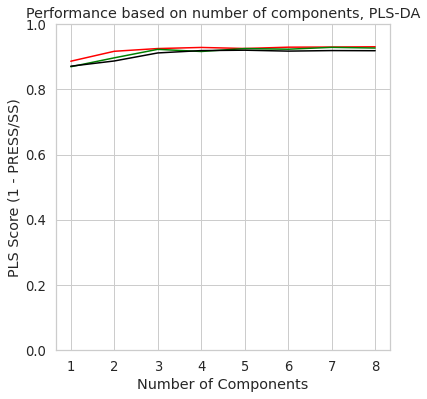

In [77]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))
        
        ax.plot(range(1, len(GAN_optim_pls) + 1), GAN_optim_pls, color='red', label='GAN Data')
        ax.plot(range(1, len(corr_optim_pls) + 1), corr_optim_pls, color='green', label='Corr Data')
        ax.plot(range(1, len(noise_optim_pls) + 1), noise_optim_pls, color='black', label='Noise Data')
        ax.set(xlabel='Number of Components',
                ylabel='PLS Score (1 - PRESS/SS)',
                title='Performance based on number of components, PLS-DA')
        ax.set_ylim([0, 1])

Fitting the model - GAN Data

In [78]:
#%%capture --no-stdout
# Capture warnings on this cell

#cv_plsda_model = ma.PLSDA_model_CV(predictions, pd.get_dummies(['No Recurrence']*(len(predictions)//2) + [
#                   'Recurrence']*(len(predictions)//2)).values[:,0], n_comp=4,
#                   n_fold=5, iter_num=20,
#                   encode2as1vector=True, feat_type='Coef')

#print('CV Accuracy Score of GAN Generated Data:', np.mean(cv_plsda_model['accuracy'])*100, '%.')

In [79]:
GAN_lbls = ['No Recurrence']*(len(predictions)//2) + [
    'Recurrence']*(len(predictions)//2)

plsda = ma.fit_PLSDA_model(predictions, GAN_lbls, n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)
test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(GAN_lbls), True)
# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(GAN_lbls), True)
# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 95.58232931726907 %.


Fitting the model - CorrGAN Data

In [80]:
#%%capture --no-stdout
# Capture warnings on this cell

#cv_plsda_model = ma.PLSDA_model_CV(corr_preds, [i[4:] for i in list(corr_lbls)], n_comp=4,
#                   n_fold=5, iter_num=20,
#                   encode2as1vector=True, feat_type='Coef')

#print('CV Accuracy Score of Correlated GAN Generated Data:', np.mean(cv_plsda_model['accuracy'])*100, '%.')

In [81]:
# Classifier Accuracy 
plsda = ma.fit_PLSDA_model(corr_preds, list(corr_lbls),
                           n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)
test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(GAN_lbls), True)
# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(GAN_lbls), True)
# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')
# Classifier Accuracy 

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 95.83333333333334 %.
Predicting Experimental Data 88.35341365461848 %.


Fitting the model - Noise Data

In [82]:
#%%capture --no-stdout
# Capture warnings on this cell

# Cross Validation Score
#cv_plsda_model = ma.PLSDA_model_CV(int_noise_df, int_noise_lbls, n_comp=4,
#                   n_fold=5, iter_num=20,
#                   encode2as1vector=True, feat_type='Coef')

#np.mean(cv_plsda_model['accuracy'])

In [83]:
# Classifier Accuracy 
plsda = ma.fit_PLSDA_model(int_noise_df, int_noise_lbls,
                           n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)

test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(int_noise_lbls), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(int_noise_lbls), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 99.59839357429718 %.


PLS-DA projections

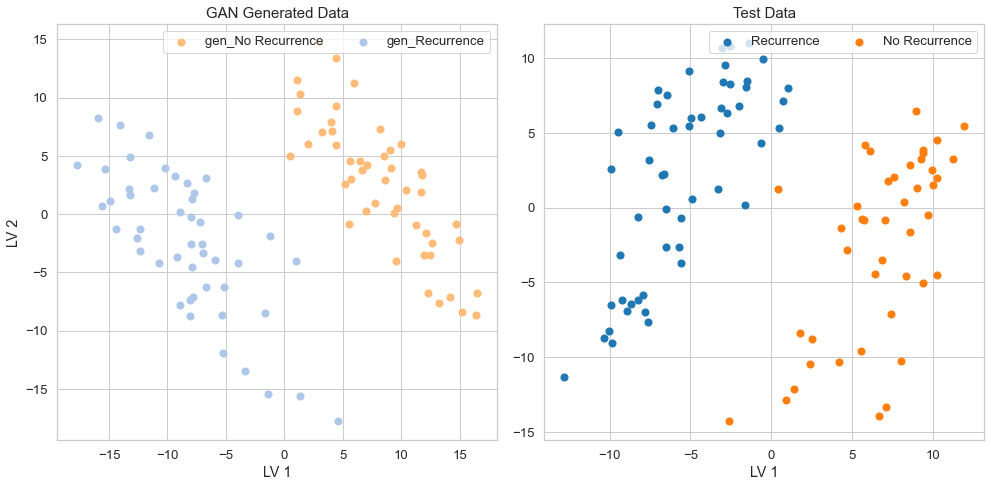

In [86]:
saved_predictions = []

num_examples_to_generate = 96
test_input = tf.constant(input_realdata_dist.rvs(size=len(data_bin_gen.columns)*num_examples_to_generate), 
                         shape=[num_examples_to_generate,len(data_bin_gen.columns)])
tl = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

p = generator([test_input, tl], training=False)
p = tf.argmax(p, p.get_shape().ndims-1) # Select the highest probability between the 0 or 1 value
saved_predictions.append(pd.DataFrame(p.numpy(), columns=data_bin_gen.columns))
GAN_data = saved_predictions[-1]

GAN_labels_2 = ['gen_No Recurrence']*(len(GAN_data)//2) + ['gen_Recurrence']*(len(GAN_data)//2)
#t_labels_2 = ['vinifera' for i in true_labels[-3*batch_size:] if i==0 else 'wild']


model, scores = ma.fit_PLSDA_model(GAN_data, GAN_labels_2, n_comp=4)
model2, scores2 = ma.fit_PLSDA_model(t_data, t_labels, n_comp=4)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="GAN Generated Data", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        gem.plot_PLS(scores2, lcolors, title="Test Data", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)
        axl.legend(loc='upper right', ncol=2)
        plt.tight_layout()
        plt.show()

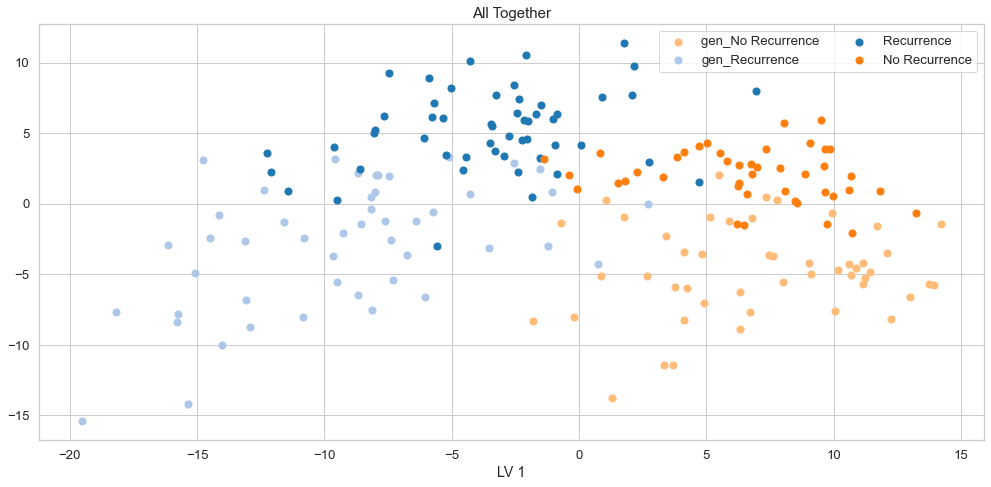

In [87]:
n_components = 4

df_temp = pd.concat([GAN_data, t_data])
labels_temp = GAN_labels_2 + list(t_labels)

model, scores = ma.fit_PLSDA_model(df_temp, labels_temp, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="All Together", ax=ax)

        ax.set_ylabel('')
        ax.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

Deep Learning methodology

In [88]:
def deep_classifier(len_input):
    
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax', use_bias=True)])
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier

Fitting the model - GAN Data

In [89]:
deep_class = deep_classifier(len(last_preds.columns))
model = deep_class.fit(last_preds, pd.get_dummies(GAN_lbls)[['No Recurrence', 'Recurrence']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['No Recurrence', 'Recurrence']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['No Recurrence', 'Recurrence']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['No Recurrence', 'Recurrence']])

Epoch 1/100
32/32 [==============================] - 2s 53ms/step - loss: 0.1277 - accuracy: 0.9463 - val_loss: 20.4336 - val_accuracy: 0.5422
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0124 - accuracy: 0.9971 - val_loss: 31.7283 - val_accuracy: 0.4578
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0141 - accuracy: 0.9951 - val_loss: 0.3514 - val_accuracy: 0.8795
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.4161 - val_accuracy: 0.8755
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.2037 - val_accuracy: 0.9357
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.8881 - val_accuracy: 0.6908
Epoch 7/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.2295 - val_accuracy: 0.9237
Epoc

32/32 [==============================] - 0s 13ms/step - loss: 1.5401e-04 - accuracy: 1.0000 - val_loss: 0.1536 - val_accuracy: 0.9478
Epoch 58/100
32/32 [==============================] - 0s 14ms/step - loss: 8.5750e-05 - accuracy: 1.0000 - val_loss: 0.0919 - val_accuracy: 0.9719
Epoch 59/100
32/32 [==============================] - 1s 23ms/step - loss: 4.8124e-04 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.9759
Epoch 60/100
32/32 [==============================] - 1s 23ms/step - loss: 2.5541e-04 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9759
Epoch 61/100
32/32 [==============================] - 0s 16ms/step - loss: 1.7150e-04 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 0.9639
Epoch 62/100
32/32 [==============================] - 0s 13ms/step - loss: 1.7066e-05 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 0.9839
Epoch 63/100
32/32 [==============================] - 0s 14ms/step - loss: 3.3913e-05 - accuracy: 1.0000 - val_loss: 0.0411 - val_a

In [90]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 87.5 %.
Predicting Experimental Data 77.91164517402649 %.


Fitting the model - CorrGAN Data

In [91]:
deep_class = deep_classifier(len(corr_preds.columns))
model = deep_class.fit(corr_preds, pd.get_dummies([i[4:] for i in list(corr_lbls)])[['No Recurrence', 'Recurrence']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['No Recurrence', 'Recurrence']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['No Recurrence', 'Recurrence']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['No Recurrence', 'Recurrence']])

Epoch 1/100
15/15 [==============================] - 2s 50ms/step - loss: 0.2139 - accuracy: 0.9231 - val_loss: 3.9063 - val_accuracy: 0.4779
Epoch 2/100
15/15 [==============================] - 0s 30ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 15.8813 - val_accuracy: 0.4578
Epoch 3/100
15/15 [==============================] - 1s 53ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5418 - val_accuracy: 0.8715
Epoch 4/100
15/15 [==============================] - 1s 33ms/step - loss: 0.0025 - accuracy: 0.9978 - val_loss: 0.4525 - val_accuracy: 0.8876
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0185 - accuracy: 0.9956 - val_loss: 7.0003 - val_accuracy: 0.5663
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 12.8171 - val_accuracy: 0.4578
Epoch 7/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0083 - accuracy: 0.9956 - val_loss: 30.1708 - val_accuracy: 0.4578
Epo

15/15 [==============================] - 0s 15ms/step - loss: 2.4687e-04 - accuracy: 1.0000 - val_loss: 0.3688 - val_accuracy: 0.8956
Epoch 58/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0031 - accuracy: 0.9978 - val_loss: 0.2980 - val_accuracy: 0.9076
Epoch 59/100
15/15 [==============================] - 0s 26ms/step - loss: 8.7580e-04 - accuracy: 1.0000 - val_loss: 0.3246 - val_accuracy: 0.9076
Epoch 60/100
15/15 [==============================] - 0s 24ms/step - loss: 9.1786e-05 - accuracy: 1.0000 - val_loss: 0.3828 - val_accuracy: 0.8956
Epoch 61/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1951 - val_accuracy: 0.9357
Epoch 62/100
15/15 [==============================] - 0s 18ms/step - loss: 2.9731e-04 - accuracy: 1.0000 - val_loss: 0.1779 - val_accuracy: 0.9317
Epoch 63/100
15/15 [==============================] - 0s 16ms/step - loss: 1.2126e-04 - accuracy: 1.0000 - val_loss: 0.1799 - val_accuracy:

In [92]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 72.91666865348816 %.
Predicting Experimental Data 71.8875527381897 %.


Fitting the model - Noise Data

In [93]:
deep_class = deep_classifier(len(int_noise_df.columns))
model = deep_class.fit(int_noise_df, pd.get_dummies(int_noise_lbls)[['No Recurrence', 'Recurrence']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['No Recurrence', 'Recurrence']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['No Recurrence', 'Recurrence']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['No Recurrence', 'Recurrence']])

Epoch 1/100
32/32 [==============================] - 3s 49ms/step - loss: 0.1253 - accuracy: 0.9492 - val_loss: 13.2467 - val_accuracy: 0.4578
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0246 - accuracy: 0.9912 - val_loss: 4.0980 - val_accuracy: 0.4980
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0153 - accuracy: 0.9941 - val_loss: 8.2072 - val_accuracy: 0.4578
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.4021 - val_accuracy: 0.8755
Epoch 5/100
32/32 [==============================] - 1s 22ms/step - loss: 6.6739e-04 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9960
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2777 - val_accuracy: 0.9157
Epoch 7/100
32/32 [==============================] - 0s 12ms/step - loss: 3.6673e-04 - accuracy: 1.0000 - val_loss: 0.0909 - val_accuracy: 0.96

32/32 [==============================] - 1s 20ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 1.4572 - val_accuracy: 0.7791
Epoch 58/100
32/32 [==============================] - 1s 28ms/step - loss: 4.8579e-04 - accuracy: 1.0000 - val_loss: 0.6852 - val_accuracy: 0.9036
Epoch 59/100
32/32 [==============================] - 0s 15ms/step - loss: 4.1064e-04 - accuracy: 1.0000 - val_loss: 0.2704 - val_accuracy: 0.9438
Epoch 60/100
32/32 [==============================] - 0s 14ms/step - loss: 8.4212e-04 - accuracy: 1.0000 - val_loss: 0.2537 - val_accuracy: 0.9518
Epoch 61/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0891 - val_accuracy: 0.9759
Epoch 62/100
32/32 [==============================] - 1s 25ms/step - loss: 8.1112e-05 - accuracy: 1.0000 - val_loss: 0.1575 - val_accuracy: 0.9598
Epoch 63/100
32/32 [==============================] - 1s 16ms/step - loss: 2.2349e-04 - accuracy: 1.0000 - val_loss: 0.0899 - val_accuracy:

In [94]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 92.77108311653137 %.


### Comparing Important Features

See models built with the a lot of GAN generated data and the real data and compare the important features selected by both (values and identities).

In [95]:
num_examples_to_generate = 1024
test_input = tf.constant(input_realdata_dist.rvs(size=len(human_datamatrix.columns)*num_examples_to_generate), 
                         shape=[num_examples_to_generate,len(human_datamatrix.columns)])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])
predictions = generator([test_input, test_labels], training=False)
predictions = tf.argmax(predictions, predictions.get_shape().ndims-1)

In [96]:
predictions = pd.DataFrame(predictions.numpy(), columns=human_datamatrix.columns)
predictions

metabolite_name,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
0,0,0,1,1,0,1,1,1,1,0,...,1,0,1,1,1,1,1,0,0,1
1,0,0,0,1,0,1,1,1,1,0,...,1,1,0,0,1,1,1,0,1,1
2,0,0,1,0,1,1,1,1,0,0,...,0,1,1,1,0,0,1,0,0,1
3,0,0,1,1,1,1,1,1,1,0,...,0,1,1,0,1,0,1,1,0,1
4,0,0,1,1,0,1,1,1,1,0,...,0,1,1,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0,0,0,1,0,1,1,1,1,0,...,0,1,1,1,1,1,1,0,0,1
1020,0,0,1,1,1,1,1,0,0,0,...,0,0,1,1,1,0,1,0,1,1
1021,1,0,0,1,1,1,1,1,0,0,...,1,0,0,0,1,0,1,1,1,1
1022,1,0,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0


#### RF

Feature Importance judged by Gini Importance

In [97]:
np.random.seed(137532)
RF_model_GANdata = ma.RF_model(predictions, test_labels.numpy().flatten(), return_cv=False, n_trees=200)
RF_model_REALdata = ma.RF_model(data_bin, hd_labels,
                                return_cv=False, n_trees=200)
RF_model_CORRdata = ma.RF_model(corr_preds, corr_lbls, return_cv=False, n_trees=200)
RF_model_NOISEdata = ma.RF_model(int_noise_df, int_noise_lbls, return_cv=False, n_trees=200)

In [98]:
RF_model_GANdata.feature_importances_

array([2.38248833e-05, 1.10453535e-05, 7.35285237e-05, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [99]:
rf_GAN_feats = zip(range(1, len(data_bin.columns)+1), RF_model_GANdata.feature_importances_)
rf_real_feats = zip(range(1, len(data_bin.columns)+1), RF_model_REALdata.feature_importances_)
rf_corr_feats = zip(range(1, len(data_bin.columns)+1), RF_model_CORRdata.feature_importances_)
rf_noise_feats = zip(range(1, len(data_bin.columns)+1), RF_model_NOISEdata.feature_importances_)

rf_GAN_df = pd.DataFrame(rf_GAN_feats)
rf_real_df = pd.DataFrame(rf_real_feats)
rf_corr_df = pd.DataFrame(rf_corr_feats)
rf_noise_df = pd.DataFrame(rf_noise_feats)

In [100]:
#GAN_df = pd.DataFrame(GAN_feats)#.set_index('0')
sorted_GAN_feats = rf_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_GAN_feats

,1
0,
5029,0.012299
4860,0.011329
7701,0.009147
1710,0.008984
4278,0.008417
...,...
5748,0.000000
5747,0.000000
5746,0.000000


In [101]:
sorted_real_feats = rf_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = rf_corr_df.set_index(0).sort_values(by=1, ascending=False)
sorted_noise_feats = rf_noise_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats

,1
0,
1710,0.007786
4553,0.005622
8699,0.005387
4533,0.004788
7633,0.004265
...,...
5092,0.000000
5093,0.000000
5095,0.000000


In [102]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections between important features of models generated with CorrGAN or Experimental Data
intersections_corr= []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))
    
# See intersections between important features of models generated with Noise Induced or Experimental Data
intersections_noise= []
for i in range(1, len(sorted_noise_feats)):
    intersections_noise.append(len(np.intersect1d(sorted_noise_feats.index[:i], sorted_real_feats.index[:i])))  

# See intersections if features were randomly shuffled
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

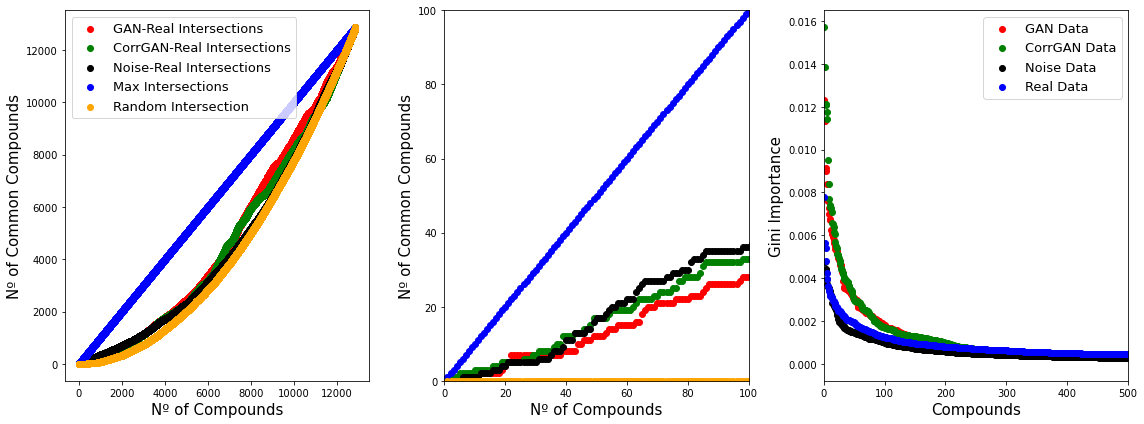

In [103]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of Gini Importance for RF models from GAN and Real Data
axr.scatter(range(1,len(rf_GAN_df)+1), rf_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(rf_corr_df)+1), rf_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(rf_noise_df)+1), rf_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise Data')
axr.scatter(range(1,len(rf_real_df)+1), rf_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,500])
axr.legend(fontsize=13)
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('Gini Importance', fontsize=15)

plt.tight_layout()
plt.show()

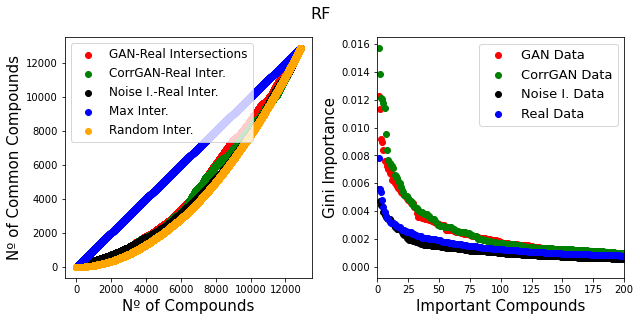

In [104]:
f, (axl, axr) = plt.subplots(1,2,figsize=(9,4.5))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Inter.', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise I.-Real Inter.', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Inter.', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Inter.', color='Orange')
axl.legend(loc='upper left', fontsize=12)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of Gini Importance for RF models from GAN and Real Data
axr.scatter(range(1,len(rf_GAN_df)+1), rf_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(rf_corr_df)+1), rf_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(rf_noise_df)+1), rf_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise I. Data')
axr.scatter(range(1,len(rf_real_df)+1), rf_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,200])
axr.legend(fontsize=13)
axr.set_xlabel('Important Compounds', fontsize=15)
axr.set_ylabel('Gini Importance', fontsize=15)

plt.suptitle('RF', fontsize=16)
plt.tight_layout()
plt.show()
f.savefig('images/HDbin_RFImpFeatPlot.png', dpi=300)

#### PLS-DA

Feature Importance judged by VIP (Variable Importance in Projection)

In [105]:
np.random.seed(137532)
PLSDA_model_GANdata = ma.fit_PLSDA_model(predictions, test_labels.numpy().flatten(), n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)
PLSDA_model_REALdata = ma.fit_PLSDA_model(data_bin, hd_labels, 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)
PLSDA_model_CORRdata = ma.fit_PLSDA_model(corr_preds, corr_lbls, 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)
PLSDA_model_NOISEdata = ma.fit_PLSDA_model(int_noise_df, int_noise_lbls, 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)

In [106]:
plsda_GAN_feats = zip(range(1, len(data_bin.columns)+1), ma._calculate_vips(PLSDA_model_GANdata))
plsda_real_feats = zip(range(1, len(data_bin.columns)+1), ma._calculate_vips(PLSDA_model_REALdata))
plsda_corr_feats = zip(range(1, len(data_bin.columns)+1), ma._calculate_vips(PLSDA_model_CORRdata))
plsda_noise_feats = zip(range(1, len(data_bin.columns)+1), ma._calculate_vips(PLSDA_model_NOISEdata))

plsda_GAN_df = pd.DataFrame(plsda_GAN_feats)
plsda_real_df = pd.DataFrame(plsda_real_feats)
plsda_corr_df = pd.DataFrame(plsda_corr_feats)
plsda_noise_df = pd.DataFrame(plsda_noise_feats)

In [107]:
# Sorting from most to least important feature
sorted_GAN_feats = plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats = plsda_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = plsda_corr_df.set_index(0).sort_values(by=1, ascending=False)
sorted_noise_feats = plsda_noise_df.set_index(0).sort_values(by=1, ascending=False)

In [108]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

intersections_corr = []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections between important features of models generated with NoiseInduced or Experimental Data
intersections_noise= []
for i in range(1, len(sorted_noise_feats)):
    intersections_noise.append(len(np.intersect1d(sorted_noise_feats.index[:i], sorted_real_feats.index[:i]))) 

# See intersections if features were randomly shuffled  
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

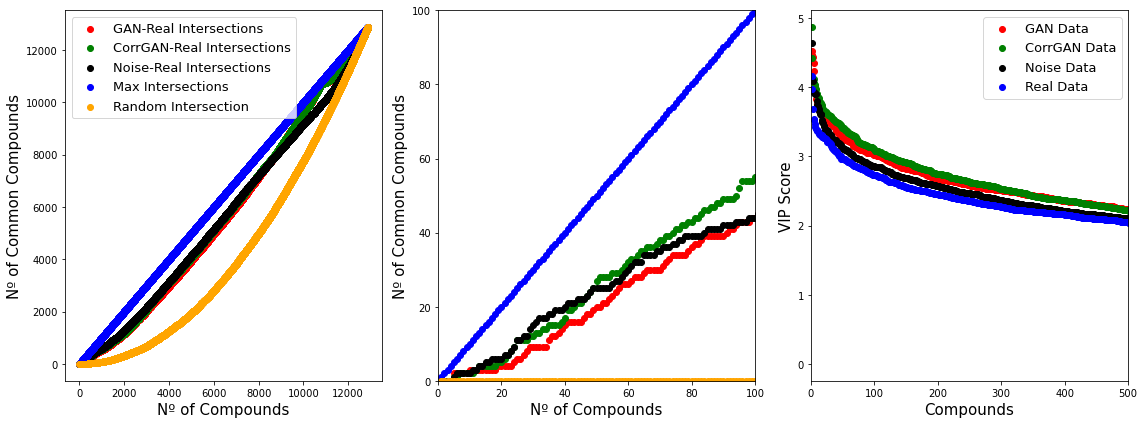

In [109]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))

# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of VIP Score for PLS-DA models from GAN and Real Data
axr.scatter(range(1,len(plsda_GAN_df)+1), plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(plsda_corr_df)+1), plsda_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(plsda_noise_df)+1), plsda_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise Data')
axr.scatter(range(1,len(plsda_real_df)+1), plsda_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,500])
axr.legend(fontsize=13)
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('VIP Score', fontsize=15)

plt.tight_layout()
plt.show()

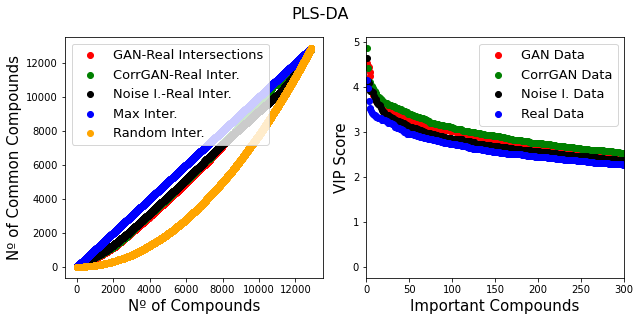

In [110]:
f, (axl, axr) = plt.subplots(1,2,figsize=(9,4.5))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Inter.', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise I.-Real Inter.', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Inter.', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Inter.', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of VIP Score for PLS-DA models from GAN and Real Data
axr.scatter(range(1,len(plsda_GAN_df)+1), plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(plsda_corr_df)+1), plsda_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(plsda_noise_df)+1), plsda_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise I. Data')
axr.scatter(range(1,len(plsda_real_df)+1), plsda_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,300])
axr.legend(fontsize=13)
axr.set_xlabel('Important Compounds', fontsize=15)
axr.set_ylabel('VIP Score', fontsize=15)

plt.suptitle('PLS-DA', fontsize=16)
plt.tight_layout()
plt.show()
f.savefig('images/HDbin_PLSDAImpFeatPlot.png', dpi=300)

### Variation on CAS (Classification Accuracy Score)

Variation on CAS Score, here we divided our dataset, getting 7 folds where each has 15 Recurrence and 15 No Recurrence samples that act as the 'training set' and the rest acts as the 'test set'.

With the train set, we build  and train a GAN model from them. Then we build models with the train set and with generated artificial samples from the GAN models and compare the performance in discriminating the test set.

In [31]:
rng = np.random.default_rng(7519)

permutation_rec = list(rng.permutation(114))

permutation_norec = list(rng.permutation(125) + 114)

In [32]:
folds_train = {}
folds_test = {}

for i in range(0, 7):
    train_idxs = permutation_rec[15*i:15*(i+1)] + permutation_norec[15*i:15*(i+1)]
    test_idxs = permutation_rec[:15*i] + permutation_rec[
        15*(i+1):] + permutation_norec[:15*i] + permutation_norec[15*(i+1):]
    
    test_lbls = ['Recurrence'] * (114 - 15) + ['No Recurrence'] * (125 - 15)
    train_lbls = ['Recurrence'] * 15 + ['No Recurrence'] * 15
    
    train_data = data_bin.iloc[train_idxs].copy()
    
    test_data = data_bin.iloc[test_idxs].copy()
    
    folds_test[i+1] = [test_data, test_lbls] 
    folds_train[i+1] = [train_data, train_lbls]
    
    print(i)

0
1
2
3
4
5
6


In [33]:
import linear_augmentation_functions as laf
arti_folds_train = {}

for i in folds_train:
    start = perf_counter()
    data, lbls = laf.artificial_dataset_generator(folds_train[i][0], labels=folds_train[i][1],
                                            max_new_samples_per_label=512, binary='random sampling',
                                            rnd=list(np.linspace(0.1,0.9,9)), 
                                            binary_rnd_state=None, rnd_state=None)
    arti_folds_train[i] = [data, lbls]
    end = perf_counter()
    print(f'Simple augmentation of train data fold {i} done! took {(end - start):.3f} s.')

Simple augmentation of train data fold 1 done! took 292.896 s.
Simple augmentation of train data fold 2 done! took 298.349 s.
Simple augmentation of train data fold 3 done! took 276.965 s.
Simple augmentation of train data fold 4 done! took 278.492 s.
Simple augmentation of train data fold 5 done! took 290.914 s.
Simple augmentation of train data fold 6 done! took 283.712 s.
Simple augmentation of train data fold 7 done! took 293.303 s.


In [34]:
data

metabolite_name,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
Arti S30_3-S14_3_rnd0.1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
Arti S20A_2-S13B_1_rnd0.4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
Arti S20A_2-S18_1_rnd0.3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
Arti S28_1-S18_1_rnd0.8,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
Arti S46_2-S43_2_rnd0.5,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Arti S59_2-S10_1_rnd0.7,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
Arti S62_1-S58_3_rnd0.4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
Arti S58_3-S73_1_rnd0.7,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
Arti S53_2-S15_3_rnd0.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


Training the network

In [44]:
def training_montage(data, lbls, epochs, generator, critic, generator_optimizer, critic_optimizer, input_dist,
                    batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15):
    """Train a generator and critic of CWGAN-GP-Binary.
    
       Receives data and respective class labels data and lbls), divides it into training and test  data and trains a generator
    and a critic model (generator, critic) over a number of epochs (epochs) with a set batch size (batch_size)
    with the respective optimizers and learning rate (generator_optimizer, critic_optimizer). Gradient Penalty is
    calculated with grad_pen_weight as the weight of the penalty.
       The functions returns at time intervals three graphs to evaluate the progression of the models (Loss plots, coverage,
    density, crossLID and correct first cluster plots and PCA plot with generated and test data). To this end, samples need
    to be generated requiring the distribution to sample the initial input values from (input_dist). Finally the number of
    neighbors to consider for coverage/density and crossLID calculation is also needed (k_cov_den, k_crossLID).
    
       data: Pandas DataFrame with data;
       lbls: List with data class labels;
       epochs: Int value with the number of epochs to train the model;
       generator: tensorflow keras.engine.functional.Functional model for the generator;
       critic: tensorflow keras.engine.functional.Functional model for the critic;
       generator_optimizer: tensorflow keras optimizer (with learning rate) for generator;
       critic_optimizer: tensorflow keras optimizer (with learning rate) for critic;
       input_dist: scipy.stats._continuous_distns.rv_histogram object - distribution to sample input values for generator;
       batch_size: int value with size of batch for model training;
       grad_pen_weight: int value (default 10) for penalty weight in gradient penalty calculation;
       k_cov_den: int value (default 50) for number of neighbors to consider for coverage and density calculation in generated
    samples evaluation;
       k_crossLID: int value (default 15) for number of neighbors to consider for crossLID calculation in generated samples
    evaluation.
    """
    
    # Obtaining the train and test data from all_data, randomizing its order
    all_data = data.iloc[np.random.RandomState(seed=145).permutation(len(data))]
    
    # Divide data into training and test data
    test_data = all_data.values
    training_data = all_data
    train_data = all_data.values
    
    # Change class labels to numerical values while following the randomized ordered of samples
    if len(set(lbls)) < 3: # 1 and 0 for when there are only two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values[:,0]
    else: # One hot encoding for when there are more than two classes
        true_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).values
    # Save the order of the labels
    ordered_labels = pd.get_dummies(
            np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).columns

    test_labels = true_labels#[-3*batch_size:]
    train_labels = true_labels#[:-3*batch_size]#, shape=(len(all_data-3*batch_size,1))

    # To save the model after
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     critic_optimizer=critic_optimizer,
                                     generator=generator,
                                     critic=critic)

    half_batch = int(batch_size / 2) 
    batch_divisions = int(batch_size / len(set(lbls))) # See how many samples of each class will be in each batch
    n_steps = epochs * int(training_data.shape[0] / batch_size)
    n_critic = 5
    
    # Set up the evaluating images printed during training and the intervals they will be updated
    f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))
    update1 = n_steps//200
    update2 = n_steps//20

    if hasattr(tqdm, '_instances'):
        tqdm._instances.clear() # clear if it exists
        
    i=0

    for step in tqdm(range(n_steps)):
        
        # Critic Training
        crit_loss_temp = []
        
        # Select real samples for this batch on training and order samples to put samples of the same class together
        real_samp = train_data[i*batch_size:(i+1)*batch_size]
        real_lbls = train_labels[i*batch_size:(i+1)*batch_size]

        real_samp_2 = np.empty(real_samp.shape)
        real_labels = np.empty(real_lbls.shape)
        a = 0
        for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: pair[0], reverse=True):
            real_samp_2[a] = s
            real_labels[a] = l
            a = a+1
        
        #ones = np.count_nonzero(real_labels == 1)
        #zeros = np.count_nonzero(real_labels == 0)
        
        # Transform real samples to have for each feature two values (probability of the value being 0 or 1) to give as an
        # acceptable input to the critic. In this case the probability of being 0 or 1, since the values are already set are
        # 100% (1) or 0% (0)
        real_samples = tf.one_hot(tf.cast(real_samp_2, 'int32'), 2)
            
        for _ in range(n_critic):  # For each step, train critic n_critic times
            
            # Generate artificial samples as input for generator
            artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
            artificial_labels = real_labels.copy()
            
            artificial_samples = generator([artificial_samples, artificial_labels], training=True) # Get the artificial samples
            
            with tf.GradientTape() as crit_tape:

                # Get the logits for the generated samples
                X_artificial = critic([artificial_samples, artificial_labels], training=True)
                # Get the logits for the real samples
                X_true = critic([real_samples, real_labels], training=True)

                # Calculate the critic loss using the generated and real sample results
                c_cost = critic_loss_wgan(X_true, X_artificial)

                # Calculate the gradient penalty
                grad_pen = gradient_penalty_cwgan_bin(batch_size, real_samples, artificial_samples,
                                                      real_labels, artificial_labels, critic)
                # Add the gradient penalty to the original discriminator loss
                crit_loss = c_cost + grad_pen * grad_pen_weight
                #print(crit_loss)
                #crit_loss = c_cost
                
            crit_loss_temp.append(crit_loss)

            # Calculate and apply the gradients obtained from the loss on the trainable variables
            gradients_of_critic = crit_tape.gradient(crit_loss, critic.trainable_variables)
            #print(gradients_of_critic)
            critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
        
        crit_loss_all.append(np.mean(crit_loss_temp))

        i = i + 1
        if (step+1) % (n_steps//epochs) == 0:
            i=0
        
        # Generator Training
        # Generate inputs for generator, values and labels
        artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
        
        if len(set(lbls)) < 3:
            artificial_labels = tf.constant([1.0]*(batch_size//2) + [0.0]*(batch_size//2), shape=(batch_size,1))
        else:
            artificial_labels = np.array(pd.get_dummies([i for i in range(len(set(train_lbls)))]*batch_divisions))
        #artificial_labels = tf.constant([1.0]*half_batch + [0.0]*half_batch, shape=(batch_size,1))
        
        with tf.GradientTape() as gen_tape: # See the gradient for the generator
            # Generate artificial samples
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            # Get the critic results for generated samples
            X_artificial = critic([artificial_samples, artificial_labels], training=True)
            # Calculate the generator loss
            gen_loss = generator_loss_wgan(X_artificial)
        
        # Calculate and apply the gradients obtained from the loss on the trainable variables
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        #print(gradients_of_generator)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        gen_loss_all.append(gen_loss)

        # Update the progress bar and evaluation graphs every update1 steps for loss plots and update2 for the others.
        if (step + 1) % update1 == 0:
            
            # Update the evaluating figures at the set intervals
            axl.clear() # Always clear the corresponding ax before redrawing it
            
            # Loss Plot
            axl.plot(gen_loss_all, color = 'blue', label='Generator Loss')
            axl.plot(crit_loss_all,color = 'red', label='Critic Loss')
            axl.set_xlabel('Number of Steps')
            axl.set_ylabel('Loss')
            axl.legend()
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        if (step + 1) % update2 == 0:
            
            # 2 steps to generate samples: 1) apply the generator; 2) then choose if the value is 0 or 1 for each feature
            # based on the probabilities generated by the generator
            f_samp = generate_predictions(generator, 96, all_data.shape[1], input_realdata_dist, ordered_labels)
            f_samples = tf.argmax(f_samp, f_samp.get_shape().ndims-1)
            saved_predictions.append(f_samples)
            
            # See density and coverage and crossLID (divided by 50 to be in the same order as the rest) of latest predictions
            artificial_labels = tf.constant([1.0]*(96//2) + [0.0]*(96//2), shape=(96,1))
            den, cov = gem.evaluation_coverage_density(
                all_data, saved_predictions[-1], k=k_cov_den, metric='jaccard')
            clid = gem.cross_LID_estimator_byMLE(
                all_data, saved_predictions[-1], k=k_crossLID, metric='jaccard')/50
            density.append(den)
            coverage.append(cov)
            crossLID.append(clid)

            # PCA of the latest predictions and training data
            dfs_temp = pd.concat((training_data,pd.DataFrame(
                saved_predictions[-1].numpy(), columns=training_data.columns)))
            temp_lbls = list(np.array(lbls)[np.random.RandomState(seed=145).permutation(len(lbls))]).copy()
            temp_lbls.extend(['gen_No Recurrence']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_Recurrence']*(len(saved_predictions[-1])//2))
            principaldf = gem.pca_sample_projection(dfs_temp, temp_lbls, pca, whiten=True, 
                                                samp_number=len(data.index))
            lcolors = label_colors_test

            # Hierarchical clustering of the latest predictions and testing data, 
            # saving the correct 1st cluster fraction results
            dfs_temp = np.concatenate((test_data, saved_predictions[-1].numpy()))
            temp_lbls = ['real']*len(test_data) + ['gen']*len(saved_predictions[-1])
            hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='average')
            corr1stcluster.append(hca_results['correct 1st clustering'])
            
            # Plots
            axc.clear()
            axc.plot(range(update2, step+2, update2), coverage, label='coverage')
            axc.plot(range(update2, step+2, update2), density, label='density')
            axc.plot(range(update2, step+2, update2), crossLID, color='red', label='crossLID')
            axc.plot(range(update2, step+2, update2), corr1stcluster, color='purple', label='corr_cluster')
            axc.legend()

            axr.clear()
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
            axr.legend(loc='upper right', ncol=1, framealpha=1)
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
        # Save the model every so often
        if (step + 1) % (update2*5) == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)      

In [40]:
GENERATE = True
arti_train = arti_folds_train

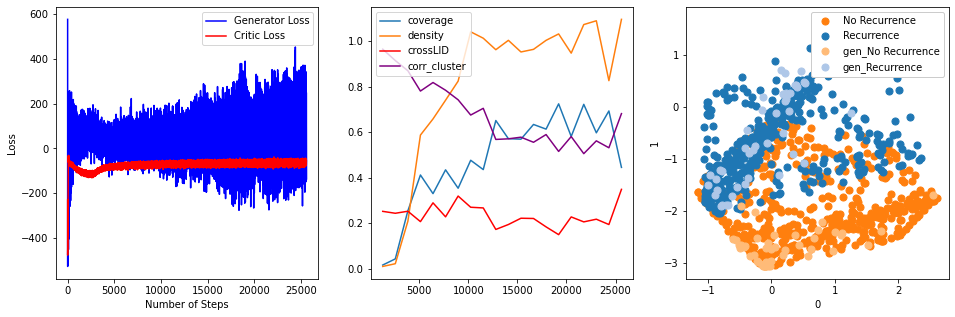

100%|██████████████████████████████████████████████████████████████████████████| 25600/25600 [2:31:13<00:00,  2.82it/s]


Fold 7 done.


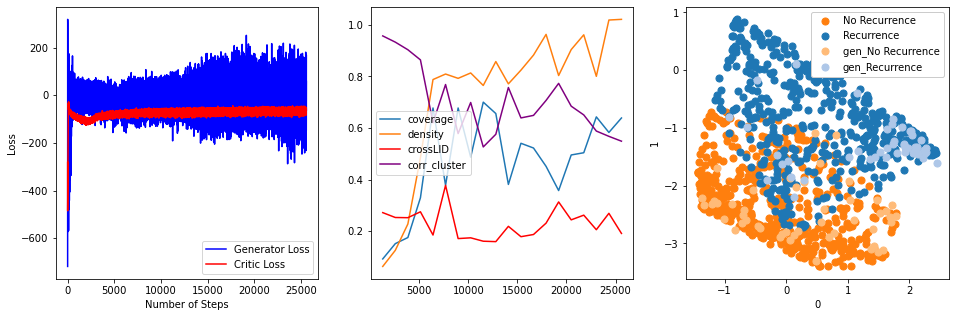

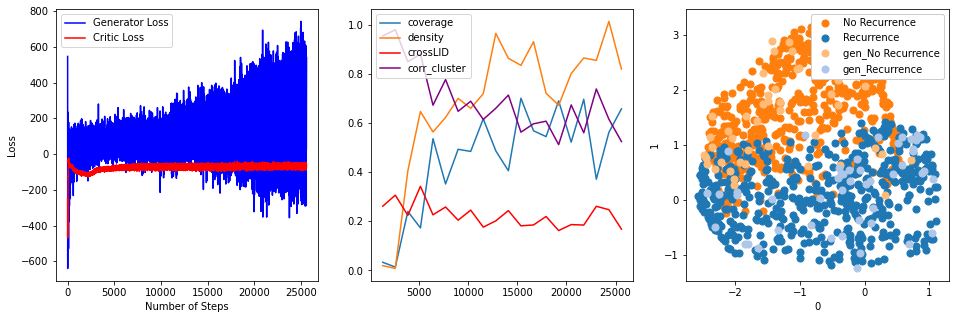

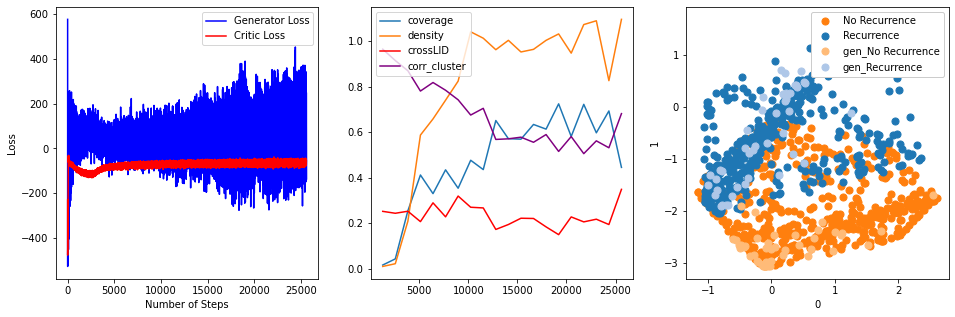

In [37]:
# Train models to generate samples for each fold
if GENERATE:
    generator_train = {}
    critic_train = {}

    results_train = {}

    #for i in arti_train:
    for i in [5,6,7]:
        generator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
        critic_optimizer = tf.keras.optimizers.RMSprop(1e-3)

        df = arti_train[i][0]
        pca = PCA(n_components=2, svd_solver='full', whiten=True)
        pc_coords = pca.fit_transform(df)

        gen_loss_all = []
        crit_loss_all = []
        saved_predictions = []
        coverage = []
        density = []
        crossLID = []
        corr1stcluster = []

        generator_train[i] = generator_model(arti_train[i][0].shape[1], arti_train[i][0].shape[1], 2, 256)
        critic_train[i] = critic_model(arti_train[i][0].shape[1], 2, 512)

        training_montage(arti_train[i][0], arti_train[i][1],
                         800, generator_train[i], critic_train[i], generator_optimizer, critic_optimizer,
                         input_realdata_dist, batch_size, grad_pen_weight=5, k_cov_den=20, k_crossLID=15)

        results_train[i] = {'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all, 'preds':saved_predictions,
                            'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1stcluster': corr1stcluster}

        print(f'Fold {i} done.')

In [39]:
# Save the models and results
import csv
GENERATE=True
if GENERATE:
    for i in generator_train:
        # Save the entire model as a SavedModel.
        generator_train[i].save_weights('gan_models/bin_HD_gen_CV'+str(i))
        critic_train[i].save_weights('gan_models/bin_HD_crit_CV'+str(i))
        
    for i in generator_train:
        print(i)
        try:
            with open('gan_models/bin_HD_results_CV'+str(i)+'.csv', 'w') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=results_train[i].keys())
                writer.writeheader()
                writer.writerow(results_train[i])
        except IOError:
            print("I/O error")

5
6
7


In [35]:
# Read back the models
GENERATE=False
if not GENERATE:
    generator_train = {}
    #generator_test = {}
    critic_train = {}
    #critic_test = {}

    results_train = {}

    for i in range(1,8):

        generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
        critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

        #df = arti_train[i][0]
        #pca = PCA(n_components=2, svd_solver='full', whiten=True)
        #pc_coords = pca.fit_transform(df)

        generator_train[i] = generator_model(folds_train[i][0].shape[1], folds_train[i][0].shape[1], 2, 256)
        critic_train[i] = critic_model(folds_train[i][0].shape[1], 2, 512)

        # Load Previously saved models
        generator_train[i].load_weights('./gan_models/bin_HD_gen_CV'+str(i))
        critic_train[i].load_weights('./gan_models/bin_HD_crit_CV'+str(i))

#### Generate samples and make Random Forests and PLS-DA models

In [36]:
np.random.seed(5407)
generated_samples = {}

for i in generator_train:
    num_examples_to_generate = 1024
    test_input = tf.constant(input_realdata_dist.rvs(size=len(folds_train[i][0].columns)*num_examples_to_generate), shape=[
        num_examples_to_generate,len(folds_train[i][0].columns)])
    test_labels = tf.constant([0]*(num_examples_to_generate//2) + [1]*(num_examples_to_generate//2), shape=[
            num_examples_to_generate,1])
    
    predictions = generator_train[i]([test_input, test_labels], training=False)
    
    predictions = tf.argmax(predictions, predictions.get_shape().ndims-1)
    
    generated_samples[i] = [pd.DataFrame(np.array(predictions), columns=folds_train[i][0].columns),
                            ['Recurrence']*(num_examples_to_generate//2) + ['No Recurrence']*(num_examples_to_generate//2)]

In [38]:
# To store for each fold
corr_generated_samples = {}

for i in generator_train:
    df = folds_train[i][0]
    # Calculate all correlations between all samples of real and artificial data and store them in a dataframe
    correlations = pd.DataFrame(index=generated_samples[i][0].index, columns=df.index).astype('float')

    for l in df.index:
        for j in generated_samples[i][0].index:
            correlations.loc[j,l] = stats.pearsonr(df.loc[l],
                                                   generated_samples[i][0].loc[j])[0]
            
    idx_to_keep = []
    for l in correlations:
        idx_to_keep.extend(correlations[l].sort_values(ascending=False).index[:5])
        
    print('Fold nº', i)
    print('Nº of total idx :', len(idx_to_keep))
    print('Nº of unique idx:', len(set(idx_to_keep)))
    
    corr_preds = generated_samples[i][0].loc[list(set(idx_to_keep))]
    corr_lbls  = np.array(generated_samples[i][1])[list(set(idx_to_keep))]
    
    corr_generated_samples[i] = [corr_preds, corr_lbls]

Fold nº 1
Nº of total idx : 150
Nº of unique idx: 144
Fold nº 2
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 3
Nº of total idx : 150
Nº of unique idx: 142
Fold nº 4
Nº of total idx : 150
Nº of unique idx: 145
Fold nº 5
Nº of total idx : 150
Nº of unique idx: 148
Fold nº 6
Nº of total idx : 150
Nº of unique idx: 150
Fold nº 7
Nº of total idx : 150
Nº of unique idx: 146


Induced noise and intensity imputation samples

In [42]:
# To store for each fold
noise_generated_samples = {}

for i in arti_train.keys():

    start = perf_counter()
    db = arti_train[i][0].copy()
    noise_df = arti_train[i][0].copy()
    for l in range(len(db.index)):
        if arti_train[i][1][l] == 'Recurrence':
            noise_df.iloc[l] = laf.imbalanced_noise_inducer(
                db.iloc[l], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
                data = arti_train[i][0].loc[np.array(arti_train[i][1])=='Recurrence'])
        else:
            noise_df.iloc[l] = laf.imbalanced_noise_inducer(
                db.iloc[l], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
                data = arti_train[i][0].loc[np.array(arti_train[i][1])=='No Recurrence'])

    noise_generated_samples[i] = [noise_df.copy(), arti_train[i][1]]
    end = perf_counter()
    print(f'Noise Induced and Imputation augmentation of data done on fold {i}! took {(end - start):.3f} s')

Noise Induced and Imputation augmentation of data done on fold 1! took 51.705 s
Noise Induced and Imputation augmentation of data done on fold 2! took 54.537 s
Noise Induced and Imputation augmentation of data done on fold 3! took 53.461 s
Noise Induced and Imputation augmentation of data done on fold 4! took 53.077 s
Noise Induced and Imputation augmentation of data done on fold 5! took 53.392 s
Noise Induced and Imputation augmentation of data done on fold 6! took 52.198 s
Noise Induced and Imputation augmentation of data done on fold 7! took 50.674 s


Random Forests

In [43]:
RF_models_gen = {}
RF_models_real = {}
RF_models_corr = {}
RF_models_noise = {}

# Train the Models
for i in generated_samples:
    rf_mod = ma.RF_model(generated_samples[i][0], generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_gen[i] = rf_mod
    
    rf_mod = ma.RF_model(folds_train[i][0], folds_train[i][1], return_cv=False, n_trees=200)
    RF_models_real[i] = rf_mod
    
    rf_mod = ma.RF_model(corr_generated_samples[i][0], corr_generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_corr[i] = rf_mod
    
    rf_mod = ma.RF_model(noise_generated_samples[i][0], noise_generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_noise[i] = rf_mod

In [44]:
# Testing the RF models with the test data for each fold for real, GAN and CorrGAN Data
RF_results_gen = {}
RF_results_real = {}
RF_results_corr = {}
RF_results_noise = {}

# Test the models
for i in RF_models_gen:
    RF_results_gen[i] = RF_models_gen[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_real[i] = RF_models_real[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_corr[i] = RF_models_corr[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_noise[i] = RF_models_noise[i].score(folds_test[i][0], folds_test[i][1])

In [45]:
# See average accuracies
print('GAN Samples Model Average Accuracy:           ', np.array(list(RF_results_gen.values())).mean()*100, '%.')
print('Correlated GAN Samples Model Average Accuracy:', np.array(list(RF_results_corr.values())).mean()*100, '%.')
print('Noise Induced Samples Model Average Accuracy: ', np.array(list(RF_results_noise.values())).mean()*100, '%.')
print('Real Samples Model Average Accuracy:          ', np.array(list(RF_results_real.values())).mean()*100, '%.')

GAN Samples Model Average Accuracy:            76.14490772385508 %.
Correlated GAN Samples Model Average Accuracy: 76.34996582365004 %.
Noise Induced Samples Model Average Accuracy:  76.0082023239918 %.
Real Samples Model Average Accuracy:           76.1449077238551 %.


In [60]:
print('Generated Samples Model Average Accuracy:', np.array(list(RF_results_gen.values())).mean())
print('Real Samples Model Average Accuracy:     ', np.array(list(RF_results_real.values())).mean())

Generated Samples Model Average Accuracy: 0.7231715652768285
Real Samples Model Average Accuracy:      0.7669172932330827


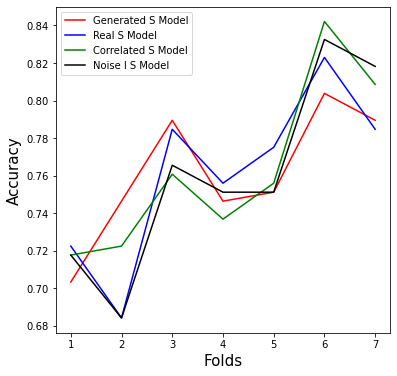

In [46]:
# Plotting the results for each fold
f, ax = plt.subplots(1,1,figsize=(6,6))
plt.plot(range(1, len(RF_results_gen)+1), RF_results_gen.values(), label='Generated S Model', color='red')
plt.plot(range(1, len(RF_results_real)+1), RF_results_real.values(), label='Real S Model', color='blue')
plt.plot(range(1, len(RF_results_corr)+1), RF_results_corr.values(), label='Correlated S Model', color='green')
plt.plot(range(1, len(RF_results_noise)+1), RF_results_noise.values(), label='Noise I S Model', color='black')
ax.legend()
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Folds', fontsize=15)
#ax.set_ylim([0.72, 0.8])
plt.show()

PLS-DA models

In [88]:
def decision_rule(y_pred, y_true):
    # Decision rule for classification
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
        else:
            pred = 0
        if pred == y_true[p]:
            nright += 1  # Correct prediction


    # Calculate accuracy for this iteration
    accuracy = (nright / len(y_pred))
    return accuracy

In [48]:
np.random.seed(5407)

PLSDA_results_gen = {}
PLSDA_results_real = {}
PLSDA_results_corr = {}
PLSDA_results_noise = {}

# Train and test the models
for i in generated_samples:
    
    # GAN Data models
    #optim_pls = ma.optim_PLSDA_n_components(
    #    generated_samples[i][0], generated_samples[i][1], encode2as1vector=True, max_comp=20, n_fold=5).CVscores
    #print(np.array(optim_pls).argmax() + 1, np.array(optim_pls).max())
    plsda = ma.fit_PLSDA_model(generated_samples[i][0], generated_samples[i][1], n_comp=4, return_scores=False, 
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(generated_samples[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_gen[i] = accuracy
    
    # Real Data models
    #optim_pls = ma.optim_PLSDA_n_components(
    #    folds_train[i][0], folds_train[i][1], encode2as1vector=True, max_comp=20, n_fold=5).CVscores
    #print(np.array(optim_pls).argmax() + 1, np.array(optim_pls).max())
    plsda = ma.fit_PLSDA_model(folds_train[i][0], folds_train[i][1], n_comp=4, return_scores=False, 
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(folds_train[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_real[i] = accuracy
    
    # CorrGAN Data models
    plsda = ma.fit_PLSDA_model(corr_generated_samples[i][0], corr_generated_samples[i][1], n_comp=4, return_scores=False, 
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(corr_generated_samples[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    #print(y_pred, y_true, accuracy)
    PLSDA_results_corr[i] = accuracy
    
    # Noise Induced and Imputed Data models
    plsda = ma.fit_PLSDA_model(noise_generated_samples[i][0], noise_generated_samples[i][1], n_comp=4,
                                              return_scores=False, scale=False, encode2as1vector=True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(noise_generated_samples[i][1]), True)
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_noise[i] = accuracy             



In [49]:
print('GAN Samples Model Average Accuracy:           ', np.array(list(PLSDA_results_gen.values())).mean()*100, '%.')
print('Correlated GAN Samples Model Average Accuracy:', np.array(list(PLSDA_results_corr.values())).mean()*100, '%.')
print('Noise Induced Samples Model Average Accuracy: ', np.array(list(PLSDA_results_noise.values())).mean()*100, '%.')
print('Real Samples Model Average Accuracy:          ', np.array(list(PLSDA_results_real.values())).mean()*100, '%.')

GAN Samples Model Average Accuracy:            75.80314422419686 %.
Correlated GAN Samples Model Average Accuracy: 77.58031442241969 %.
Noise Induced Samples Model Average Accuracy:  77.37525632262474 %.
Real Samples Model Average Accuracy:           78.74231032125768 %.


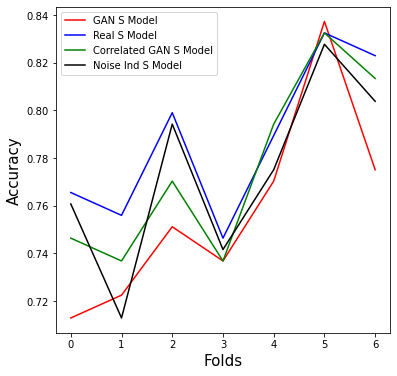

In [50]:
# Plotting the results for each fold
f, ax = plt.subplots(1,1,figsize=(6,6))
plt.plot(range(len(PLSDA_results_gen)), PLSDA_results_gen.values(), label='GAN S Model', color='red')
plt.plot(range(len(PLSDA_results_real)), PLSDA_results_real.values(), label='Real S Model', color='blue')
plt.plot(range(len(PLSDA_results_corr)), PLSDA_results_corr.values(), label='Correlated GAN S Model', color='green')
plt.plot(range(len(PLSDA_results_noise)), PLSDA_results_noise.values(), label='Noise Ind S Model', color='black')
ax.legend()
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Folds', fontsize=15)
plt.show()

Deep Learning methodology

In [51]:
def deep_classifier(len_input):
    
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax', use_bias=True)])
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier

In [52]:
# To store loss and accuracies of deep learning model
dl_loss_gen = {}
dl_loss_real = {}
dl_loss_corr = {}
dl_loss_noise = {}

dl_losstest_gen = {}
dl_losstest_real = {}
dl_losstest_corr = {}
dl_losstest_noise = {}

dl_results_gen = {}
dl_results_real = {}
dl_results_corr = {}
dl_results_noise = {}

for i in generated_samples:
    # GAN Model
    deep_class = deep_classifier(len(generated_samples[i][0].columns))
    model = deep_class.fit(generated_samples[i][0].values, 
                           pd.get_dummies(generated_samples[i][1])[['Recurrence', 'No Recurrence']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']]))
    dl_loss_gen[i] = model.history['loss']
    
    dl_losstest_gen[i], dl_results_gen[i] = deep_class.evaluate(folds_test[i][0].values, 
                                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']])

    # CorrGAN Model
    deep_class = deep_classifier(len(corr_generated_samples[i][0].columns))
    model = deep_class.fit(corr_generated_samples[i][0].values, 
                           pd.get_dummies(corr_generated_samples[i][1])[['Recurrence', 'No Recurrence']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']]))
    dl_loss_corr[i] = model.history['loss']
    
    dl_losstest_corr[i], dl_results_corr[i] = deep_class.evaluate(folds_test[i][0].values, 
                                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']])
    
    # Noise Induced and Imputed Intensity Model
    deep_class = deep_classifier(len(noise_generated_samples[i][0].columns))
    model = deep_class.fit(noise_generated_samples[i][0].values, 
                           pd.get_dummies(noise_generated_samples[i][1])[['Recurrence', 'No Recurrence']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']]))
    dl_loss_noise[i] = model.history['loss']
    
    dl_losstest_noise[i], dl_results_noise[i] = deep_class.evaluate(folds_test[i][0].values, 
                                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']])
    
    # Real Model
    deep_class = deep_classifier(len(folds_train[i][0].columns))
    model = deep_class.fit(folds_train[i][0].values, 
                           pd.get_dummies(folds_train[i][1])[['Recurrence', 'No Recurrence']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']]))
    dl_loss_real[i] = model.history['loss']
    
    dl_losstest_real[i], dl_results_real[i] = deep_class.evaluate(folds_test[i][0].values, 
                                                            pd.get_dummies(folds_test[i][1])[['Recurrence', 'No Recurrence']])
    
    print(f'Fold {i} done!')

Epoch 1/100
32/32 [==============================] - 7s 128ms/step - loss: 0.0404 - accuracy: 0.9844 - val_loss: 2.8440 - val_accuracy: 0.6077
Epoch 2/100
32/32 [==============================] - 2s 69ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.9340 - val_accuracy: 0.6411
Epoch 3/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0035 - accuracy: 0.9980 - val_loss: 35.1866 - val_accuracy: 0.4737
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0191 - accuracy: 0.9951 - val_loss: 52.1567 - val_accuracy: 0.4737
Epoch 5/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 22.9669 - val_accuracy: 0.4737
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 3.1954e-04 - accuracy: 1.0000 - val_loss: 12.6955 - val_accuracy: 0.4737
Epoch 7/100
32/32 [==============================] - 0s 7ms/step - loss: 8.5988e-04 - accuracy: 1.0000 - val_loss: 7.2551 - val_accuracy: 0.

Epoch 13/100
5/5 [==============================] - 0s 21ms/step - loss: 2.1427e-04 - accuracy: 1.0000 - val_loss: 3.9262 - val_accuracy: 0.5598
Epoch 14/100
5/5 [==============================] - 0s 21ms/step - loss: 2.4376e-04 - accuracy: 1.0000 - val_loss: 3.8070 - val_accuracy: 0.5598
Epoch 15/100
5/5 [==============================] - 0s 20ms/step - loss: 7.8923e-05 - accuracy: 1.0000 - val_loss: 3.6943 - val_accuracy: 0.5646
Epoch 16/100
5/5 [==============================] - 0s 22ms/step - loss: 1.1675e-04 - accuracy: 1.0000 - val_loss: 3.5480 - val_accuracy: 0.5742
Epoch 17/100
5/5 [==============================] - 0s 20ms/step - loss: 2.7371e-04 - accuracy: 1.0000 - val_loss: 3.3680 - val_accuracy: 0.5742
Epoch 18/100
5/5 [==============================] - 0s 22ms/step - loss: 1.0636e-04 - accuracy: 1.0000 - val_loss: 3.2379 - val_accuracy: 0.5789
Epoch 19/100
5/5 [==============================] - 0s 21ms/step - loss: 5.7875e-05 - accuracy: 1.0000 - val_loss: 3.1179 - val_ac

Epoch 25/100
32/32 [==============================] - 0s 8ms/step - loss: 2.2073e-05 - accuracy: 1.0000 - val_loss: 1.4585 - val_accuracy: 0.7512
Epoch 26/100
32/32 [==============================] - 0s 6ms/step - loss: 2.2859e-05 - accuracy: 1.0000 - val_loss: 1.5137 - val_accuracy: 0.7608
Epoch 27/100
32/32 [==============================] - 0s 6ms/step - loss: 3.4333e-05 - accuracy: 1.0000 - val_loss: 1.5042 - val_accuracy: 0.7464
Epoch 28/100
32/32 [==============================] - 0s 6ms/step - loss: 2.1614e-05 - accuracy: 1.0000 - val_loss: 1.4643 - val_accuracy: 0.7703
Epoch 29/100
32/32 [==============================] - 0s 7ms/step - loss: 5.8459e-06 - accuracy: 1.0000 - val_loss: 1.4384 - val_accuracy: 0.7751
Epoch 30/100
32/32 [==============================] - 0s 6ms/step - loss: 1.3640e-05 - accuracy: 1.0000 - val_loss: 1.4838 - val_accuracy: 0.7368
Epoch 31/100
32/32 [==============================] - 0s 7ms/step - loss: 9.2476e-06 - accuracy: 1.0000 - val_loss: 1.4740 -

Epoch 37/100
1/1 [==============================] - 0s 75ms/step - loss: 1.1677e-04 - accuracy: 1.0000 - val_loss: 8.5065 - val_accuracy: 0.5311
Epoch 38/100
1/1 [==============================] - 0s 78ms/step - loss: 1.1220e-04 - accuracy: 1.0000 - val_loss: 8.3915 - val_accuracy: 0.5311
Epoch 39/100
1/1 [==============================] - 0s 94ms/step - loss: 1.0804e-04 - accuracy: 1.0000 - val_loss: 8.2690 - val_accuracy: 0.5311
Epoch 40/100
1/1 [==============================] - 0s 71ms/step - loss: 1.0472e-04 - accuracy: 1.0000 - val_loss: 8.1460 - val_accuracy: 0.5311
Epoch 41/100
1/1 [==============================] - 0s 80ms/step - loss: 1.0158e-04 - accuracy: 1.0000 - val_loss: 8.0318 - val_accuracy: 0.5311
Epoch 42/100
1/1 [==============================] - 0s 77ms/step - loss: 9.9008e-05 - accuracy: 1.0000 - val_loss: 7.9179 - val_accuracy: 0.5311
Epoch 43/100
1/1 [==============================] - 0s 76ms/step - loss: 9.6240e-05 - accuracy: 1.0000 - val_loss: 7.7961 - val_ac

32/32 [==============================] - 0s 7ms/step - loss: 9.3980e-06 - accuracy: 1.0000 - val_loss: 0.9949 - val_accuracy: 0.7273
Epoch 49/100
32/32 [==============================] - 0s 8ms/step - loss: 5.0518e-05 - accuracy: 1.0000 - val_loss: 1.1368 - val_accuracy: 0.7368
Epoch 50/100
32/32 [==============================] - 0s 7ms/step - loss: 3.9432e-06 - accuracy: 1.0000 - val_loss: 1.0815 - val_accuracy: 0.7321
Epoch 51/100
32/32 [==============================] - 0s 7ms/step - loss: 1.1697e-05 - accuracy: 1.0000 - val_loss: 1.0246 - val_accuracy: 0.7464
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 2.2359e-05 - accuracy: 1.0000 - val_loss: 0.8998 - val_accuracy: 0.7751
Epoch 53/100
32/32 [==============================] - 0s 8ms/step - loss: 1.1819e-05 - accuracy: 1.0000 - val_loss: 0.8820 - val_accuracy: 0.7703
Epoch 54/100
32/32 [==============================] - 0s 8ms/step - loss: 2.4278e-05 - accuracy: 1.0000 - val_loss: 1.0171 - val_accuracy

Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.4022 - val_accuracy: 0.6029
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.5951 - val_accuracy: 0.6890
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 5.5218e-04 - accuracy: 1.0000 - val_loss: 3.1203 - val_accuracy: 0.6316
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 3.3532e-04 - accuracy: 1.0000 - val_loss: 4.4228 - val_accuracy: 0.5789
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 5.1135 - val_accuracy: 0.5646
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 4.3177e-04 - accuracy: 1.0000 - val_loss: 4.9658 - val_accuracy: 0.5646
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 2.5976e-04 - accuracy: 1.0000 - val_loss: 4.9100 - val_accuracy: 0.5646
Epo

32/32 [==============================] - 0s 6ms/step - loss: 6.5583e-05 - accuracy: 1.0000 - val_loss: 2.3861 - val_accuracy: 0.6842
Epoch 17/100
32/32 [==============================] - 0s 6ms/step - loss: 6.6507e-05 - accuracy: 1.0000 - val_loss: 2.2032 - val_accuracy: 0.6890
Epoch 18/100
32/32 [==============================] - 0s 6ms/step - loss: 7.2911e-05 - accuracy: 1.0000 - val_loss: 2.2548 - val_accuracy: 0.6890
Epoch 19/100
32/32 [==============================] - 0s 7ms/step - loss: 3.0030e-05 - accuracy: 1.0000 - val_loss: 3.2251 - val_accuracy: 0.6364
Epoch 20/100
32/32 [==============================] - 0s 7ms/step - loss: 1.1367e-04 - accuracy: 1.0000 - val_loss: 1.5790 - val_accuracy: 0.7081
Epoch 21/100
32/32 [==============================] - 0s 7ms/step - loss: 2.4020e-05 - accuracy: 1.0000 - val_loss: 1.5540 - val_accuracy: 0.7225
Epoch 22/100
32/32 [==============================] - 0s 6ms/step - loss: 3.3408e-05 - accuracy: 1.0000 - val_loss: 1.7344 - val_accuracy

1/1 [==============================] - 0s 44ms/step - loss: 1.4211e-04 - accuracy: 1.0000 - val_loss: 2.4278 - val_accuracy: 0.5646
Epoch 29/100
1/1 [==============================] - 0s 43ms/step - loss: 1.3153e-04 - accuracy: 1.0000 - val_loss: 2.1473 - val_accuracy: 0.5885
Epoch 30/100
1/1 [==============================] - 0s 50ms/step - loss: 1.2394e-04 - accuracy: 1.0000 - val_loss: 1.9104 - val_accuracy: 0.5837
Epoch 31/100
1/1 [==============================] - 0s 49ms/step - loss: 1.1721e-04 - accuracy: 1.0000 - val_loss: 1.7166 - val_accuracy: 0.6077
Epoch 32/100
1/1 [==============================] - 0s 50ms/step - loss: 1.1148e-04 - accuracy: 1.0000 - val_loss: 1.5455 - val_accuracy: 0.6268
Epoch 33/100
1/1 [==============================] - 0s 43ms/step - loss: 1.0587e-04 - accuracy: 1.0000 - val_loss: 1.4062 - val_accuracy: 0.6459
Epoch 34/100
1/1 [==============================] - 0s 47ms/step - loss: 1.0247e-04 - accuracy: 1.0000 - val_loss: 1.2926 - val_accuracy: 0.660

Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 7.8040e-06 - accuracy: 1.0000 - val_loss: 1.3575 - val_accuracy: 0.7464
Epoch 41/100
32/32 [==============================] - 0s 8ms/step - loss: 1.1291e-05 - accuracy: 1.0000 - val_loss: 1.3865 - val_accuracy: 0.7416
Epoch 42/100
32/32 [==============================] - 0s 7ms/step - loss: 1.3734e-05 - accuracy: 1.0000 - val_loss: 1.4229 - val_accuracy: 0.7416
Epoch 43/100
32/32 [==============================] - 0s 7ms/step - loss: 1.5809e-05 - accuracy: 1.0000 - val_loss: 1.4340 - val_accuracy: 0.7416
Epoch 44/100
32/32 [==============================] - 0s 7ms/step - loss: 1.2296e-05 - accuracy: 1.0000 - val_loss: 1.4432 - val_accuracy: 0.7416
Epoch 45/100
32/32 [==============================] - 0s 8ms/step - loss: 1.4346e-05 - accuracy: 1.0000 - val_loss: 1.4461 - val_accuracy: 0.7416
Epoch 46/100
32/32 [==============================] - 0s 7ms/step - loss: 7.1507e-05 - accuracy: 1.0000 - val_loss: 1.5770 -

5/5 [==============================] - 0s 18ms/step - loss: 1.4429e-05 - accuracy: 1.0000 - val_loss: 0.7285 - val_accuracy: 0.8182
Epoch 53/100
5/5 [==============================] - 0s 18ms/step - loss: 4.7517e-05 - accuracy: 1.0000 - val_loss: 0.7307 - val_accuracy: 0.8134
Epoch 54/100
5/5 [==============================] - 0s 18ms/step - loss: 4.6490e-05 - accuracy: 1.0000 - val_loss: 0.7352 - val_accuracy: 0.8086
Epoch 55/100
5/5 [==============================] - 0s 17ms/step - loss: 6.8582e-05 - accuracy: 1.0000 - val_loss: 0.7473 - val_accuracy: 0.8038
Epoch 56/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7586e-05 - accuracy: 1.0000 - val_loss: 0.7561 - val_accuracy: 0.7990
Epoch 57/100
5/5 [==============================] - 0s 23ms/step - loss: 6.4676e-05 - accuracy: 1.0000 - val_loss: 0.7705 - val_accuracy: 0.8038
Epoch 58/100
5/5 [==============================] - 0s 19ms/step - loss: 1.9726e-05 - accuracy: 1.0000 - val_loss: 0.7824 - val_accuracy: 0.813

32/32 [==============================] - 0s 6ms/step - loss: 1.1013e-04 - accuracy: 1.0000 - val_loss: 2.7243 - val_accuracy: 0.6268
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 2.4991e-04 - accuracy: 1.0000 - val_loss: 4.6441 - val_accuracy: 0.5981
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 8.3276e-05 - accuracy: 1.0000 - val_loss: 1.1107 - val_accuracy: 0.8134
Epoch 11/100
32/32 [==============================] - 0s 6ms/step - loss: 5.2415e-05 - accuracy: 1.0000 - val_loss: 1.0358 - val_accuracy: 0.7847
Epoch 12/100
32/32 [==============================] - 0s 6ms/step - loss: 5.0166e-04 - accuracy: 1.0000 - val_loss: 8.1544 - val_accuracy: 0.5311
Epoch 13/100
32/32 [==============================] - 0s 6ms/step - loss: 4.1872e-05 - accuracy: 1.0000 - val_loss: 5.8458 - val_accuracy: 0.5694
Epoch 14/100
32/32 [==============================] - 0s 6ms/step - loss: 7.5598e-05 - accuracy: 1.0000 - val_loss: 1.0766 - val_accuracy:

1/1 [==============================] - 0s 42ms/step - loss: 2.3438e-04 - accuracy: 1.0000 - val_loss: 2.0418 - val_accuracy: 0.6459
Epoch 21/100
1/1 [==============================] - 0s 42ms/step - loss: 2.1305e-04 - accuracy: 1.0000 - val_loss: 2.0289 - val_accuracy: 0.6507
Epoch 22/100
1/1 [==============================] - 0s 41ms/step - loss: 1.9406e-04 - accuracy: 1.0000 - val_loss: 2.0008 - val_accuracy: 0.6603
Epoch 23/100
1/1 [==============================] - 0s 41ms/step - loss: 1.8110e-04 - accuracy: 1.0000 - val_loss: 1.9752 - val_accuracy: 0.6603
Epoch 24/100
1/1 [==============================] - 0s 42ms/step - loss: 1.7044e-04 - accuracy: 1.0000 - val_loss: 1.9480 - val_accuracy: 0.6651
Epoch 25/100
1/1 [==============================] - 0s 41ms/step - loss: 1.6178e-04 - accuracy: 1.0000 - val_loss: 1.9204 - val_accuracy: 0.6746
Epoch 26/100
1/1 [==============================] - 0s 41ms/step - loss: 1.5441e-04 - accuracy: 1.0000 - val_loss: 1.8924 - val_accuracy: 0.674

Epoch 32/100
32/32 [==============================] - 0s 8ms/step - loss: 1.2811e-04 - accuracy: 1.0000 - val_loss: 1.8886 - val_accuracy: 0.6699
Epoch 33/100
32/32 [==============================] - 0s 8ms/step - loss: 2.5340e-05 - accuracy: 1.0000 - val_loss: 2.1772 - val_accuracy: 0.6986
Epoch 34/100
32/32 [==============================] - 0s 7ms/step - loss: 1.1606e-05 - accuracy: 1.0000 - val_loss: 3.5125 - val_accuracy: 0.6316
Epoch 35/100
32/32 [==============================] - 0s 8ms/step - loss: 5.4025e-05 - accuracy: 1.0000 - val_loss: 2.0724 - val_accuracy: 0.6746
Epoch 36/100
32/32 [==============================] - 0s 8ms/step - loss: 1.1916e-05 - accuracy: 1.0000 - val_loss: 1.4211 - val_accuracy: 0.7464
Epoch 37/100
32/32 [==============================] - 0s 9ms/step - loss: 8.7681e-06 - accuracy: 1.0000 - val_loss: 1.2959 - val_accuracy: 0.7464
Epoch 38/100
32/32 [==============================] - 0s 8ms/step - loss: 5.2610e-05 - accuracy: 1.0000 - val_loss: 1.3246 -

5/5 [==============================] - 0s 22ms/step - loss: 6.1736e-05 - accuracy: 1.0000 - val_loss: 1.1481 - val_accuracy: 0.7703
Epoch 45/100
5/5 [==============================] - 0s 18ms/step - loss: 1.9724e-05 - accuracy: 1.0000 - val_loss: 1.1415 - val_accuracy: 0.7512
Epoch 46/100
5/5 [==============================] - 0s 18ms/step - loss: 3.5489e-05 - accuracy: 1.0000 - val_loss: 1.1383 - val_accuracy: 0.7464
Epoch 47/100
5/5 [==============================] - 0s 17ms/step - loss: 2.9204e-05 - accuracy: 1.0000 - val_loss: 1.1362 - val_accuracy: 0.7368
Epoch 48/100
5/5 [==============================] - 0s 17ms/step - loss: 5.2451e-05 - accuracy: 1.0000 - val_loss: 1.1354 - val_accuracy: 0.7368
Epoch 49/100
5/5 [==============================] - 0s 17ms/step - loss: 1.0123e-04 - accuracy: 1.0000 - val_loss: 1.1364 - val_accuracy: 0.7368
Epoch 50/100
5/5 [==============================] - 0s 17ms/step - loss: 5.8924e-05 - accuracy: 1.0000 - val_loss: 1.1395 - val_accuracy: 0.741

Epoch 56/100
32/32 [==============================] - 0s 7ms/step - loss: 5.7085e-06 - accuracy: 1.0000 - val_loss: 2.3919 - val_accuracy: 0.7177
Epoch 57/100
32/32 [==============================] - 0s 9ms/step - loss: 8.3038e-06 - accuracy: 1.0000 - val_loss: 2.3162 - val_accuracy: 0.7368
Epoch 58/100
32/32 [==============================] - 0s 9ms/step - loss: 4.0291e-06 - accuracy: 1.0000 - val_loss: 2.3122 - val_accuracy: 0.7416
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 4.5762e-06 - accuracy: 1.0000 - val_loss: 2.3132 - val_accuracy: 0.7416
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 5.8913e-06 - accuracy: 1.0000 - val_loss: 2.3088 - val_accuracy: 0.7416
Epoch 61/100
32/32 [==============================] - 0s 7ms/step - loss: 4.0933e-06 - accuracy: 1.0000 - val_loss: 2.2943 - val_accuracy: 0.7368
Epoch 62/100
32/32 [==============================] - 0s 7ms/step - loss: 2.4893e-05 - accuracy: 1.0000 - val_loss: 2.1983 -

Epoch 12/100
1/1 [==============================] - 0s 58ms/step - loss: 9.4876e-04 - accuracy: 1.0000 - val_loss: 30.3281 - val_accuracy: 0.4737
Epoch 13/100
1/1 [==============================] - 0s 46ms/step - loss: 8.1259e-04 - accuracy: 1.0000 - val_loss: 31.3966 - val_accuracy: 0.4737
Epoch 14/100
1/1 [==============================] - 0s 45ms/step - loss: 7.2094e-04 - accuracy: 1.0000 - val_loss: 32.2454 - val_accuracy: 0.4737
Epoch 15/100
1/1 [==============================] - 0s 43ms/step - loss: 6.4077e-04 - accuracy: 1.0000 - val_loss: 32.8933 - val_accuracy: 0.4737
Epoch 16/100
1/1 [==============================] - 0s 42ms/step - loss: 5.6977e-04 - accuracy: 1.0000 - val_loss: 33.3331 - val_accuracy: 0.4737
Epoch 17/100
1/1 [==============================] - 0s 42ms/step - loss: 5.0584e-04 - accuracy: 1.0000 - val_loss: 33.6426 - val_accuracy: 0.4737
Epoch 18/100
1/1 [==============================] - 0s 43ms/step - loss: 4.5353e-04 - accuracy: 1.0000 - val_loss: 33.7988 -

32/32 [==============================] - 0s 7ms/step - loss: 8.0553e-06 - accuracy: 1.0000 - val_loss: 1.5196 - val_accuracy: 0.7368
Epoch 24/100
32/32 [==============================] - 0s 8ms/step - loss: 1.6418e-06 - accuracy: 1.0000 - val_loss: 1.5046 - val_accuracy: 0.7416
Epoch 25/100
32/32 [==============================] - 0s 7ms/step - loss: 3.5902e-06 - accuracy: 1.0000 - val_loss: 1.4856 - val_accuracy: 0.7464
Epoch 26/100
32/32 [==============================] - 0s 7ms/step - loss: 2.1483e-05 - accuracy: 1.0000 - val_loss: 1.6010 - val_accuracy: 0.7273
Epoch 27/100
32/32 [==============================] - 0s 7ms/step - loss: 4.3180e-06 - accuracy: 1.0000 - val_loss: 1.5447 - val_accuracy: 0.7368
Epoch 28/100
32/32 [==============================] - 0s 8ms/step - loss: 2.0543e-06 - accuracy: 1.0000 - val_loss: 1.5388 - val_accuracy: 0.7368
Epoch 29/100
32/32 [==============================] - 0s 8ms/step - loss: 1.7795e-06 - accuracy: 1.0000 - val_loss: 1.5174 - val_accuracy

5/5 [==============================] - 0s 15ms/step - loss: 8.9113e-06 - accuracy: 1.0000 - val_loss: 1.6696 - val_accuracy: 0.7033
Epoch 36/100
5/5 [==============================] - 0s 19ms/step - loss: 3.7125e-05 - accuracy: 1.0000 - val_loss: 1.6354 - val_accuracy: 0.7081
Epoch 37/100
5/5 [==============================] - 0s 17ms/step - loss: 2.9520e-06 - accuracy: 1.0000 - val_loss: 1.5986 - val_accuracy: 0.7129
Epoch 38/100
5/5 [==============================] - 0s 18ms/step - loss: 8.0577e-06 - accuracy: 1.0000 - val_loss: 1.5665 - val_accuracy: 0.7177
Epoch 39/100
5/5 [==============================] - 0s 18ms/step - loss: 4.4074e-06 - accuracy: 1.0000 - val_loss: 1.5324 - val_accuracy: 0.7225
Epoch 40/100
5/5 [==============================] - 0s 17ms/step - loss: 1.7977e-05 - accuracy: 1.0000 - val_loss: 1.5022 - val_accuracy: 0.7225
Epoch 41/100
5/5 [==============================] - 0s 19ms/step - loss: 3.9511e-05 - accuracy: 1.0000 - val_loss: 1.4852 - val_accuracy: 0.722

Epoch 47/100
32/32 [==============================] - 0s 6ms/step - loss: 4.4182e-06 - accuracy: 1.0000 - val_loss: 2.1071 - val_accuracy: 0.7225
Epoch 48/100
32/32 [==============================] - 0s 7ms/step - loss: 7.8821e-06 - accuracy: 1.0000 - val_loss: 1.8463 - val_accuracy: 0.7512
Epoch 49/100
32/32 [==============================] - 0s 7ms/step - loss: 9.8948e-06 - accuracy: 1.0000 - val_loss: 1.8430 - val_accuracy: 0.7512
Epoch 50/100
32/32 [==============================] - 0s 6ms/step - loss: 6.6291e-06 - accuracy: 1.0000 - val_loss: 1.7898 - val_accuracy: 0.7608
Epoch 51/100
32/32 [==============================] - 0s 6ms/step - loss: 6.1216e-06 - accuracy: 1.0000 - val_loss: 1.7675 - val_accuracy: 0.7608
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 1.8447e-05 - accuracy: 1.0000 - val_loss: 2.1359 - val_accuracy: 0.7177
Epoch 53/100
32/32 [==============================] - 0s 7ms/step - loss: 4.5720e-06 - accuracy: 1.0000 - val_loss: 1.8972 -

1/1 [==============================] - 0s 58ms/step - loss: 3.3667e-05 - accuracy: 1.0000 - val_loss: 15.8821 - val_accuracy: 0.4737
Epoch 59/100
1/1 [==============================] - 0s 60ms/step - loss: 3.3099e-05 - accuracy: 1.0000 - val_loss: 15.6402 - val_accuracy: 0.4737
Epoch 60/100
1/1 [==============================] - 0s 58ms/step - loss: 3.2908e-05 - accuracy: 1.0000 - val_loss: 15.4037 - val_accuracy: 0.4737
Epoch 61/100
1/1 [==============================] - 0s 57ms/step - loss: 3.2197e-05 - accuracy: 1.0000 - val_loss: 15.1719 - val_accuracy: 0.4737
Epoch 62/100
1/1 [==============================] - 0s 58ms/step - loss: 3.1999e-05 - accuracy: 1.0000 - val_loss: 14.9463 - val_accuracy: 0.4737
Epoch 63/100
1/1 [==============================] - 0s 55ms/step - loss: 3.1585e-05 - accuracy: 1.0000 - val_loss: 14.7217 - val_accuracy: 0.4737
Epoch 64/100
1/1 [==============================] - 0s 56ms/step - loss: 3.0962e-05 - accuracy: 1.0000 - val_loss: 14.5072 - val_accuracy

32/32 [==============================] - 0s 12ms/step - loss: 9.2678e-06 - accuracy: 1.0000 - val_loss: 0.7915 - val_accuracy: 0.7943
Epoch 70/100
32/32 [==============================] - 0s 11ms/step - loss: 4.8206e-06 - accuracy: 1.0000 - val_loss: 0.7709 - val_accuracy: 0.7895
Epoch 71/100
32/32 [==============================] - 0s 10ms/step - loss: 6.3540e-06 - accuracy: 1.0000 - val_loss: 0.8527 - val_accuracy: 0.7751
Epoch 72/100
32/32 [==============================] - 0s 13ms/step - loss: 2.6640e-06 - accuracy: 1.0000 - val_loss: 0.9073 - val_accuracy: 0.7560
Epoch 73/100
32/32 [==============================] - 0s 10ms/step - loss: 4.1503e-06 - accuracy: 1.0000 - val_loss: 0.8587 - val_accuracy: 0.7799
Epoch 74/100
32/32 [==============================] - 0s 8ms/step - loss: 3.7844e-05 - accuracy: 1.0000 - val_loss: 1.7029 - val_accuracy: 0.6699
Epoch 75/100
32/32 [==============================] - 0s 11ms/step - loss: 4.8019e-06 - accuracy: 1.0000 - val_loss: 1.7896 - val_ac

Epoch 25/100
5/5 [==============================] - 0s 15ms/step - loss: 5.9424e-05 - accuracy: 1.0000 - val_loss: 3.8237 - val_accuracy: 0.5550
Epoch 26/100
5/5 [==============================] - 0s 15ms/step - loss: 7.5339e-04 - accuracy: 1.0000 - val_loss: 4.4400 - val_accuracy: 0.5455
Epoch 27/100
5/5 [==============================] - 0s 15ms/step - loss: 2.1913e-04 - accuracy: 1.0000 - val_loss: 4.4054 - val_accuracy: 0.5455
Epoch 28/100
5/5 [==============================] - 0s 15ms/step - loss: 4.6230e-05 - accuracy: 1.0000 - val_loss: 4.1563 - val_accuracy: 0.5502
Epoch 29/100
5/5 [==============================] - 0s 15ms/step - loss: 4.4346e-05 - accuracy: 1.0000 - val_loss: 3.9138 - val_accuracy: 0.5502
Epoch 30/100
5/5 [==============================] - 0s 15ms/step - loss: 4.1202e-05 - accuracy: 1.0000 - val_loss: 3.6960 - val_accuracy: 0.5646
Epoch 31/100
5/5 [==============================] - 0s 18ms/step - loss: 3.3257e-05 - accuracy: 1.0000 - val_loss: 3.4949 - val_ac

Epoch 37/100
32/32 [==============================] - 0s 9ms/step - loss: 4.0279e-06 - accuracy: 1.0000 - val_loss: 0.8418 - val_accuracy: 0.8230
Epoch 38/100
32/32 [==============================] - 0s 7ms/step - loss: 2.2083e-05 - accuracy: 1.0000 - val_loss: 0.8069 - val_accuracy: 0.8134
Epoch 39/100
32/32 [==============================] - 0s 8ms/step - loss: 6.7688e-06 - accuracy: 1.0000 - val_loss: 0.7750 - val_accuracy: 0.8421
Epoch 40/100
32/32 [==============================] - 0s 8ms/step - loss: 3.1663e-06 - accuracy: 1.0000 - val_loss: 0.7524 - val_accuracy: 0.8469
Epoch 41/100
32/32 [==============================] - 0s 8ms/step - loss: 1.1799e-05 - accuracy: 1.0000 - val_loss: 1.1607 - val_accuracy: 0.7512
Epoch 42/100
32/32 [==============================] - 0s 7ms/step - loss: 1.3070e-05 - accuracy: 1.0000 - val_loss: 0.7863 - val_accuracy: 0.8373
Epoch 43/100
32/32 [==============================] - 0s 8ms/step - loss: 1.2906e-05 - accuracy: 1.0000 - val_loss: 0.8279 -

32/32 [==============================] - 0s 8ms/step - loss: 1.9279e-05 - accuracy: 1.0000 - val_loss: 1.1652 - val_accuracy: 0.7608
Epoch 94/100
32/32 [==============================] - 0s 9ms/step - loss: 1.1643e-05 - accuracy: 1.0000 - val_loss: 1.0691 - val_accuracy: 0.7751
Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 4.7801e-06 - accuracy: 1.0000 - val_loss: 0.8209 - val_accuracy: 0.8325
Epoch 96/100
32/32 [==============================] - 0s 9ms/step - loss: 8.8586e-06 - accuracy: 1.0000 - val_loss: 1.5223 - val_accuracy: 0.7464
Epoch 97/100
32/32 [==============================] - 0s 7ms/step - loss: 9.6083e-06 - accuracy: 1.0000 - val_loss: 0.8321 - val_accuracy: 0.8278
Epoch 98/100
32/32 [==============================] - 0s 7ms/step - loss: 5.6558e-06 - accuracy: 1.0000 - val_loss: 0.8463 - val_accuracy: 0.8278
Epoch 99/100
32/32 [==============================] - 0s 7ms/step - loss: 1.1960e-06 - accuracy: 1.0000 - val_loss: 0.8724 - val_accuracy

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

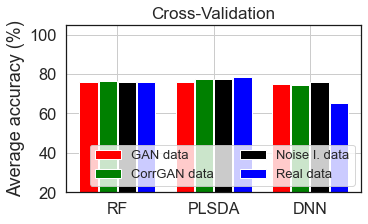

In [58]:
# Results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, axu = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
        x = np.arange(3)  # the label locations
        labels = ['RF', 'PLSDA', 'DNN']
        width = 0.19  # the width of the bars
        
        offset = - 0.3 + 0 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_gen.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_gen.values())).mean()*100,
                                                            np.array(list(dl_results_gen.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_gen.values())).std()*100, 
                                             np.array(list(PLSDA_results_gen.values())).std()*100,
                                             np.array(list(dl_results_gen.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='GAN data', color='red')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 1 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_corr.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_corr.values())).mean()*100,
                                                            np.array(list(dl_results_corr.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_corr.values())).std()*100, 
                                             np.array(list(PLSDA_results_corr.values())).std()*100,
                                             np.array(list(dl_results_corr.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='CorrGAN data', color='green')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 2 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_noise.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_noise.values())).mean()*100,
                                                            np.array(list(dl_results_noise.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_noise.values())).std()*100, 
                                             np.array(list(PLSDA_results_noise.values())).std()*100,
                                             np.array(list(dl_results_noise.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'],
                        width, label='Noise I. data', color='black')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 3 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_real.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_real.values())).mean()*100,
                                                            np.array(list(dl_results_real.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_real.values())).std()*100, 
                                             np.array(list(PLSDA_results_real.values())).std()*100,
                                             np.array(list(dl_results_real.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='Real data', color='blue')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
         #               ls='none', ecolor='0.2', capsize=3)
        
        axu.set_xticks(x)
        axu.set_xticklabels(labels, fontsize=16)
        axu.set(ylabel='Average accuracy (%)', title='', ylim=(20,105))
        for spine in axu.spines.values():
            spine.set_edgecolor('0.1')
        
        axu.legend(loc='lower right', fontsize=13, ncol=2)
        plt.title('Cross-Validation', fontsize=17)
        plt.show()
        f.savefig('images/HDbin_AccuPlot.png' , dpi=300)

### Optimizing with different parameters

In [ ]:
test_lrs = {1: 1e-5, 2:5e-5, 3: 1e-4, 4:5e-4, 5: 1e-3, 6:5e-3}

results = {}

for i, lr in test_lrs.items():

    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []

    generator_optimizer = tf.keras.optimizers.RMSprop(lr)
    critic_optimizer = tf.keras.optimizers.RMSprop(lr)

    generator = generator_model(data_bin.shape[1], all_data.shape[1], 2, 256)
    critic = critic_model(data_bin.shape[1], 2, 256)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_bin, lbls, 1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)

    results[i]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all,
                'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [ ]:
tf.debugging.set_log_device_placement(True)
test_lrs = {1: 1e-5, 2:5e-5, 3: 1e-4, 4:5e-4, 5: 1e-3, 6:5e-3}
test_opts = {1: tf.keras.optimizers.RMSprop(5e-5), 2:tf.keras.optimizers.Adadelta(5e-5),
             3: tf.keras.optimizers.Adam(5e-5), 4:tf.keras.optimizers.SGD(5e-5),
             5: tf.keras.optimizers.Ftrl(5e-5)}

results = {}

for i, opt in test_opts.items():

    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []

    generator_optimizer = opt
    critic_optimizer = opt

    generator = generator_model(data_bin.shape[1], data_bin.shape[1], 2, 256)
    critic = critic_model(data_bin.shape[1], 2, 256)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_bin, lbls, 1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15)

    results[i]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all, 'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [ ]:
import itertools
results = {}

n_hidden_nodes = [256, 512, 1024]
for n_hidden_gen, n_hidden_critic in itertools.product(n_hidden_nodes, n_hidden_nodes):

    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []

    generator_optimizer = tf.keras.optimizers.RMSprop(5e-3)
    critic_optimizer = tf.keras.optimizers.RMSprop(5e-3)

    generator = generator_model(data_bin.shape[1], data_bin.shape[1], 2, n_hidden_gen)
    critic = critic_model(data_bin.shape[1], 2, n_hidden_critic)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_bin, hd_labels, 1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)

    results[(n_hidden_gen, n_hidden_critic)]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all,
                'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}